In [1]:
from platform import python_version
print(python_version())

3.9.16


In [2]:
%matplotlib inline
#%reset
import sys
import numpy as np
import os
import math
import cv2
import shutil
import time
import random
import matplotlib.image as img
import tensorflow as tf
import itertools
from PIL import Image


# ensure we are training on GPU
# print(tf.__version__)
# print(tf.__file__)
# print(tf.config.list_physical_devices())
#print(tf.config.list_physical_devices('GPU'))

from tensorflow import keras
from keras.callbacks import EarlyStopping
#from IPython.display import Image, display
import matplotlib.pyplot as plt

ImageDataGenerator = keras.preprocessing.image.ImageDataGenerator

In [3]:
# set random seed to ensure determinism for hyperparameter comparison, without shuffling
seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)

## Base image directory path

In [4]:
BASE_IMAGE_DIR = "C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages"

## Set up data directories to cleanse data

Found 12488 images in the cat directory.
Found 12487 images in the dog directory.


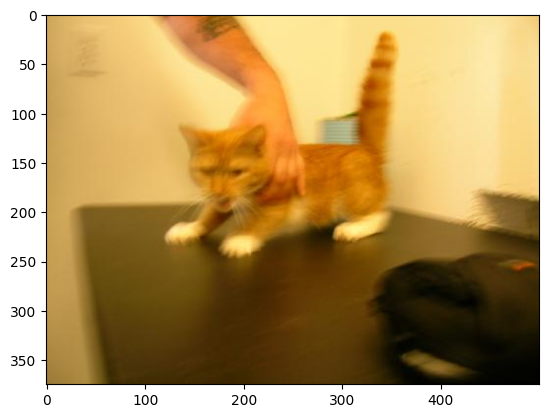

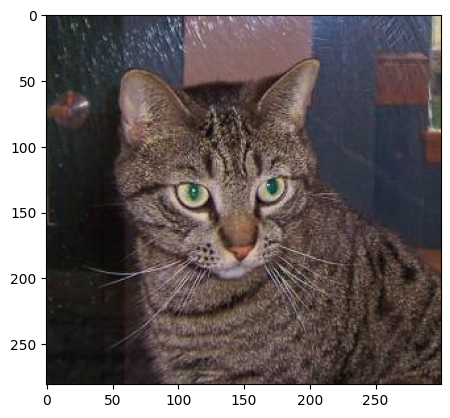

In [5]:
CAT_IMAGE_DIR = os.path.join(BASE_IMAGE_DIR, 'Cat')
DOG_IMAGE_DIR = os.path.join(BASE_IMAGE_DIR, 'Dog')
CORRUPTED_IMAGE_DIR = os.path.join(BASE_IMAGE_DIR, 'corrupted')
TRAINED_MODELS_DIR = os.path.join(BASE_IMAGE_DIR, 'models')
SAVE_DIR = r"C:\dev\programming_2023\cnn_project\training_plots"

if not os.path.exists(CORRUPTED_IMAGE_DIR):
    print("Creating {}".format(CORRUPTED_IMAGE_DIR))
    os.mkdir(CORRUPTED_IMAGE_DIR)
    
if not os.path.exists(TRAINED_MODELS_DIR):
    print("Creating {}".format(TRAINED_MODELS_DIR))
    os.mkdir(TRAINED_MODELS_DIR)

    
print("Found {} images in the cat directory.".format(len(os.listdir(CAT_IMAGE_DIR))))
print("Found {} images in the dog directory.".format(len(os.listdir(DOG_IMAGE_DIR))))

# display the first 2 images of the cat directory as a santity check
first_images = os.listdir(CAT_IMAGE_DIR)[:2]
for image in first_images:
    test_img_path = "{}/{}".format(CAT_IMAGE_DIR, image)
    test_img =  cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
    
    plt.imshow(test_img)
    plt.show()

## Remove corrupted images

In [6]:
cat_images = os.listdir(CAT_IMAGE_DIR)
for image in cat_images:
    test_img_path = "{}/{}".format(CAT_IMAGE_DIR, image)
    try:
        im = Image.open(test_img_path)
    except:
        print("Found corrupted image: {}. Moving to: {} ".format(test_img_path, CORRUPTED_IMAGE_DIR))
        corrupted_path = "{}/{}".format(CORRUPTED_IMAGE_DIR, image)
        os.rename(test_img_path, corrupted_path)
        continue

dog_images = os.listdir(DOG_IMAGE_DIR)
for image in dog_images:
    test_img_path = "{}/{}".format(DOG_IMAGE_DIR, image)
    try:
        im = Image.open(test_img_path)
    except:
        print("Found corrupted image: {}. Moving to: {} ".format(test_img_path, CORRUPTED_IMAGE_DIR))
        corrupted_path = "{}/{}".format(CORRUPTED_IMAGE_DIR, image)
        os.rename(test_img_path, corrupted_path)
        continue

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


## Parameterized class for image classifier to train and test various hyperparameters

In [7]:
class CatDogImageClassifier():
    def __init__(
        self,
        model_name,
        batch_size,
        activation_function, # currently used in the architecture params
        loss_function,
        epochs,
        layer_configs,
        dropout_rate=None
    ):
        self.model_name=model_name
        self.batch_size=batch_size
        self.activation_function=activation_function
        self.loss_function=loss_function
        self.epochs=epochs
        self.layer_configs=layer_configs
        self.dropout_rate=dropout_rate
        
        self.model=None
        self.acc=None
        self.validation_acc=None
        self.loss=None
        self.validation_loss=None
        self.results=None
        self.train_time=None
        
    def build(self):
        
        print("Building model: {}...".format(self.model_name))
        self.model=keras.models.Sequential()
        
        # build the model dynamically based on the layer configs
        for index, layer_config in enumerate(self.layer_configs):
            
            layer_type = layer_config["type"]

            if layer_type == "Conv2D":
                
                # if this is the first layer, we need to specifc the input shape
                if index == 0:
                    conv2d_layer = keras.layers.Conv2D(
                        layer_config["filters"],
                        layer_config["kernel_size"],
                        activation=self.activation_function,
                        padding="same",
                        input_shape=(256, 256,3)
                    )
                else:
                    conv2d_layer = keras.layers.Conv2D(
                        layer_config["filters"],
                        layer_config["kernel_size"],
                        activation=self.activation_function,
                        padding="same",
                    )  
                    
                self.model.add(conv2d_layer)
                    
            elif layer_type == "MaxPooling2D":
                self.model.add(
                    keras.layers.MaxPooling2D(
                        layer_config["pool_size"]
                    )
                )

            elif layer_type == "Dropout":
                
                # class-level dropout rate takes precedence
                if self.dropout_rate is None:
                    self.model.add(keras.layers.Dropout(
                        layer_config["rate"]
                        )
                    )
                else:
                    print("Using dropout rate: {}".format(self.dropout_rate))
                    self.model.add(keras.layers.Dropout(
                        self.dropout_rate
                        )
                    )

            elif layer_type == "Flatten":
                self.model.add(keras.layers.Flatten())

            elif layer_type == "Dense":
                self.model.add(keras.layers.Dense(
                    units=layer_config["units"],
                    activation=layer_config["activation"]
                ))
                
                              
        self.model.summary()
        
        print("Compiling model...")
        
        self.model.compile(
            loss=self.loss_function,
            optimizer=keras.optimizers.Adamax(learning_rate=0.001),
            metrics=['acc']
        )
        
    def train(self, image_dir):

        start = time.time()
        
        if self.model is None:
            raise Exception("Model is not yet build. Call the build() before calling train()")
        
        # expect the labels in 2 image directories
        subdirs = os.listdir(image_dir)
        
        if not 'Cat' in subdirs or not 'Dog' in subdirs:
            raise Exception("Could not find Cat and/or Dog image directory in {}".format(image_dir))
            
        # warn if we don't find a GPU to train on
        if len(tf.config.list_physical_devices('GPU')) < 1:
            print("No GPU found, training on CPU")
            print("WARNING: Training on CPU not advised.")
        
        
        base_generator = ImageDataGenerator(
            rescale=1/255,
            validation_split=.2
        )
        
        # TODO explore chaging these
        height, width=(256, 256)
        
        train_dataset = base_generator.flow_from_directory(
            image_dir,
            target_size=(height, width),
            classes=('Cat', 'Dog'),
            batch_size=self.batch_size,
            subset='training',
        )

        validation_dataset = base_generator.flow_from_directory(
            image_dir,
            target_size=(height, width),
            classes=('Cat', 'Dog'),
            batch_size=self.batch_size,
            subset='validation',
        )
        
        
        # if our validation loss isn't improving, stop training
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
        self.results = self.model.fit(
            train_dataset,
            validation_data=validation_dataset,
            workers=20,
            epochs=self.epochs
        )
        
        self.train_time = time.time() - start
        
        # set training metrics
        self.accuracy = self.results.history['acc']
        self.validation_acc = self.results.history['val_acc']
        self.loss = self.results.history['loss']
        self.validation_loss = self.results.history['val_loss']
        
        save_dir = "{}/{}/{}".format(image_dir, "models", self.model_name)
        print("Trained model. Attempting to save to: {}".format(save_dir))
        
        if not os.path.exists(save_dir):
            os.mkdir(save_dir)
            
        self.model.save(save_dir)
        
    def plot_results(self, save_dir=None):
        
        if self.results is None:
            raise Exception("No training results.")
        
        
        epochs = self.results.epoch
        
        fig, ax = plt.subplots(1, 2, figsize=(20,6))

        # plot accuracy
        ax[0].set_title("{}: Accuracy".format(self.model_name))
        ax[0].plot(epochs, self.accuracy, label='Training accuracy')
        ax[0].plot(epochs, self.validation_acc, label='Validation accuracy')
        ax[0].set_xlabel("Epoch")
        ax[0].set_xticks(epochs)
        ax[0].set_ylabel("Accuracy")
        ax[0].legend()

        # plot loss
        ax[1].set_title("{}: Loss".format(self.model_name))
        ax[1].plot(epochs, self.loss, label='Training loss')
        ax[1].plot(epochs, self.validation_loss, label='Validation loss')
        ax[1].set_xlabel("Epoch")
        ax[1].set_xticks(epochs)
        ax[1].set_ylabel("Loss")
        ax[1].legend()
        
        if save_dir is not None:
            path = "{}/{}.png".format(save_dir, self.model_name)
            plt.savefig(path)

        plt.show()

        
        

## Define the paramters based on systematic parameter sweep 

In [8]:
# best_architecture_configuration = [
#     {'type': 'Conv2D', 'filters': 24, 'kernel_size': (5, 5)}, 
#     {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, 
#     {'type': 'Conv2D', 'filters': 48, 'kernel_size': (5, 5)}, 
#     {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, 
#     {'type': 'Conv2D', 'filters': 96, 'kernel_size': (5, 5)}, 
#     {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, 
#     {'type': 'Flatten'}, 
#     {'type': 'Dropout', 'rate': 0.9}, 
#     {'type': 'Dense', 'units': 64, 'activation': 'relu'}, 
#     {'type': 'Dense', 'units': 2, 'activation': 'sigmoid'}
# ]

best_config = [
    {'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, 
    {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, 
    {'type': 'Dropout', 'rate': 0.30703886128813807}, 
    {'type': 'Flatten'}, 
    {'type': 'Dense', 'units': 256, 'activation': 'tanh'},
    {'type': 'Dense', 'units': 2, 'activation': 'softmax'}
]

best_activation_function = "relu"
best_batch_size = 30
best_loss_function = "binary_crossentropy"
best_dropout_rate = 0.9
epochs_to_train = 15

best_network = CatDogImageClassifier(
    model_name="best_classifier",
    batch_size=best_batch_size,
    activation_function=best_activation_function,
    loss_function=best_loss_function,
    layer_configs=best_architecture_configuration,
    dropout_rate=best_dropout_rate,
    epochs=epochs_to_train
    
)

In [9]:
best_network.build()
best_network.train(BASE_IMAGE_DIR)

Building model: best_classifier...
Using dropout rate: 0.9
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 24)      1824      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 24)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 48)      28848     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 48)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 96)        115296    
                                                               

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/best_classifier\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/best_classifier\assets


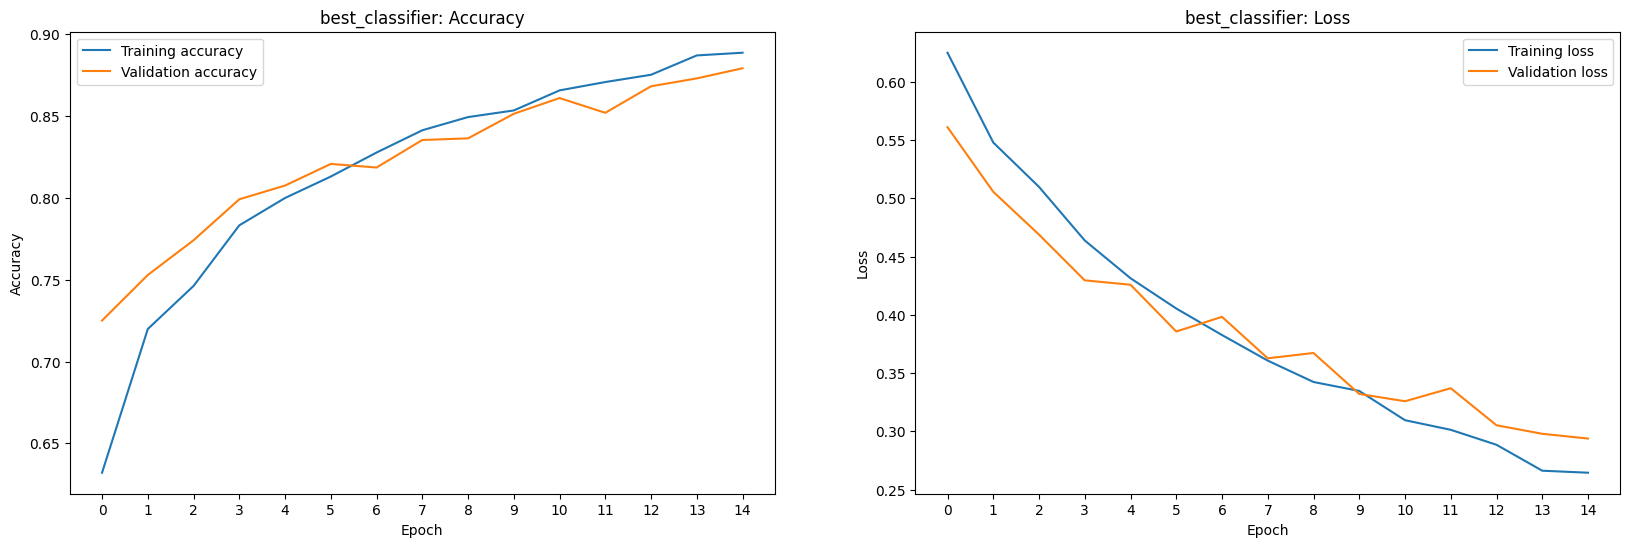

In [10]:
best_network.plot_results(save_dir=SAVE_DIR)

### Hyperparameter tuning - sweep architecture and optimization models

In [7]:
# randomly generate a 
def generate_random_layer_config(layer_type):
    if layer_type == "Conv2D":
        return {
            "type": layer_type,
            "filters": random.choice([16, 32, 64, 128]),
            "kernel_size": random.choice([(3, 3), (5, 5)])
        }

    elif layer_type == "MaxPooling2D":
        return {
            "type": layer_type,
            "pool_size": random.choice([(2, 2), (3, 3)])
        }

    elif layer_type == "Dropout":
        return {
            "type": layer_type,
            "rate": random.uniform(0.1, 0.9)
        }

    elif layer_type == "Flatten":
        return {
            "type": layer_type
        }

    elif layer_type == "Dense":
        return {
            "type": layer_type,
            "units": random.choice([64, 128, 256, 512]),
            "activation": random.choice(["relu", "sigmoid", "tanh"])
        }


def generate_constrained_layer_config_list():
    layer_list = []

    # randomly choose the number of convolutional blocks
    num_conv_blocks = random.randint(1, 4)

    # ensure any conv layer is followed by max pooling layers
    for _ in range(num_conv_blocks):
        layer_list.append(generate_random_layer_config("Conv2D"))
        layer_list.append(generate_random_layer_config("MaxPooling2D"))

        # Optionally add dropout layers after MaxPooling2D layers
        if random.random() < 0.5:
            layer_list.append(generate_random_layer_config("Dropout"))

    # add a Flatten layer before the first Dense layer
    layer_list.append(generate_random_layer_config("Flatten"))

    # randomly choose the number of dense layers (excluding the last one)
    num_dense_layers = random.randint(0, 2)

    for _ in range(num_dense_layers):
        layer_list.append(generate_random_layer_config("Dense"))

    # The last layer is Dense with softmax activation
    layer_list.append({
        "type": "Dense",
        "units": 2,
        "activation": "softmax"
    })

    return layer_list

test = generate_constrained_layer_config_list()
print(test)

[{'type': 'Conv2D', 'filters': 64, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.39123098704841297}, {'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Conv2D', 'filters': 128, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 128, 'activation': 'sigmoid'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]


In [8]:
# define an function to sweep architecutre params
def sweep_architecture_params(image_dir, n_trials, other_params):
    best_validation_acc = 0
    best_config = None

    for trial in range(n_trials):
        config = generate_constrained_layer_config_list()
        print("Testing architecture config (trial {}): {}".format(trial + 1, config))

        model = CatDogImageClassifier(
            model_name="architecture_sweep",
            batch_size=other_params["batch_size"],
            activation_function=other_params["activation_function"],
            loss_function=other_params["loss_function"],
            epochs=other_params["epochs"],
            layer_configs=config
        )

        try:
            model.build()
            model.train(image_dir)
            model.plot_results()
        except Exception as e:
            print("Failed to train: {}".format(e))
            continue

        # grab the highest-achieved validation accuracy
        current_validation_acc = max(model.validation_acc)

        if current_validation_acc > best_validation_acc:
            best_validation_acc = current_validation_acc
            best_config = config

        print("Current best validation accuracy: ", best_validation_acc)

    return best_config


# define a function to sweep non-config params - (run after we decided on overall architecture)
def grid_search(image_dir, layer_configs, activation_functions, batch_sizes, loss_functions, epochs_list, dropout_rates):

    # Generate all combinations of parameters
    param_combinations = list(itertools.product(activation_functions, batch_sizes, loss_functions, epochs_list, dropout_rates))

    results = []

    for activation_function, batch_size, loss_function, epoch, dropout_rate in param_combinations:
        model_name = f"model_{activation_function}_{batch_size}_{loss_function}_{epoch}_{dropout_rate}"
        print(f"Training model: {model_name}")

        # create and build the model with the current parameter combination
        classifier = CatDogImageClassifier(
            model_name=model_name,
            batch_size=batch_size,
            activation_function=activation_function,
            loss_function=loss_function,
            epochs=epoch,
            layer_configs=layer_configs,
            dropout_rate=dropout_rate
        )

        classifier.build()
        classifier.train(image_dir)

        # Append the results to the results list
        results.append({
            'model_name': model_name,
            'activation_function': activation_function,
            'batch_size': batch_size,
            'loss_function': loss_function,
            'epochs': epoch,
            'accuracy': classifier.accuracy,
            'validation_accuracy': classifier.validation_acc,
            'loss': classifier.loss,
            'validation_loss': classifier.validation_loss
        })
        
    return results



Testing architecture config (trial 1): [{'type': 'Conv2D', 'filters': 16, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Conv2D', 'filters': 32, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 128, 'activation': 'relu'}, {'type': 'Dense', 'units': 256, 'activation': 'relu'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 85, 85, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 85, 85,

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 28s 38ms/step - loss: 0.5780 - acc: 0.6882 - val_loss: 0.5079 - val_acc: 0.7527
Epoch 2/15
625/625 [==============================] - 27s 43ms/step - loss: 0.4674 - acc: 0.7766 - val_loss: 0.4569 - val_acc: 0.7897
Epoch 3/15
625/625 [==============================] - 24s 38ms/step - loss: 0.4034 - acc: 0.8177 - val_loss: 0.4333 - val_acc: 0.7998
Epoch 4/15
625/625 [==============================] - 27s 43ms/step - loss: 0.3477 - acc: 0.8444 - val_loss: 0.4306 - val_acc: 0.7990
Epoch 5/15
625/625 [==============================] - 27s 42ms/step - loss: 0.2824 - acc: 0.8815 - val_loss: 0.4266 - val_acc: 0.8112
Epoch 6/15
625/625 [==============================] - 24s 38ms/step - loss: 0.2114 - acc: 0.9116 - val_loss: 0.4754 - val_acc: 0.8058
Epoch 7/15
625/625 [==============================] - 25s 39ms/step - loss: 0.1449 - acc: 0.9434 - val_loss: 0.5516 - val_acc: 0.7972
Epoch 8/15
625/625 [==============================] - 22s 36ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


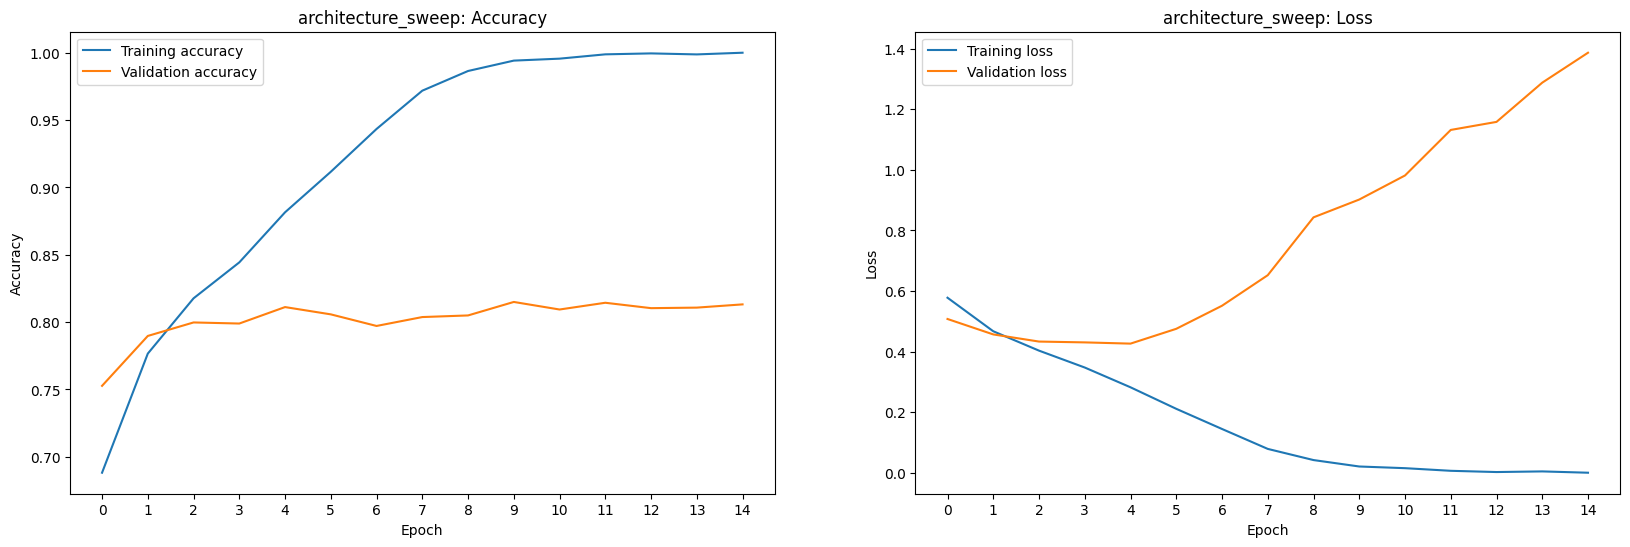

Current best validation accuracy:  0.8149779438972473
Testing architecture config (trial 2): [{'type': 'Conv2D', 'filters': 32, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Dropout', 'rate': 0.44040286078970714}, {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.24940431881065522}, {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 256, 256, 32)      2432      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 85, 85, 32)       0         
 2D)                    

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 32s 49ms/step - loss: 0.6719 - acc: 0.5668 - val_loss: 0.6272 - val_acc: 0.6754
Epoch 2/15
625/625 [==============================] - 29s 46ms/step - loss: 0.5780 - acc: 0.6913 - val_loss: 0.5545 - val_acc: 0.7275
Epoch 3/15
625/625 [==============================] - 31s 49ms/step - loss: 0.5356 - acc: 0.7269 - val_loss: 0.5087 - val_acc: 0.7569
Epoch 4/15
625/625 [==============================] - 33s 53ms/step - loss: 0.4981 - acc: 0.7604 - val_loss: 0.5099 - val_acc: 0.7447
Epoch 5/15
625/625 [==============================] - 34s 55ms/step - loss: 0.4681 - acc: 0.7789 - val_loss: 0.4604 - val_acc: 0.7811
Epoch 6/15
625/625 [==============================] - 29s 46ms/step - loss: 0.4403 - acc: 0.7977 - val_loss: 0.4535 - val_acc: 0.7819
Epoch 7/15
625/625 [==============================] - 33s 52ms/step - loss: 0.4139 - acc: 0.8158 - val_loss: 0.4148 - val_acc: 0.8128
Epoch 8/15
625/625 [==============================] - 30s 48ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


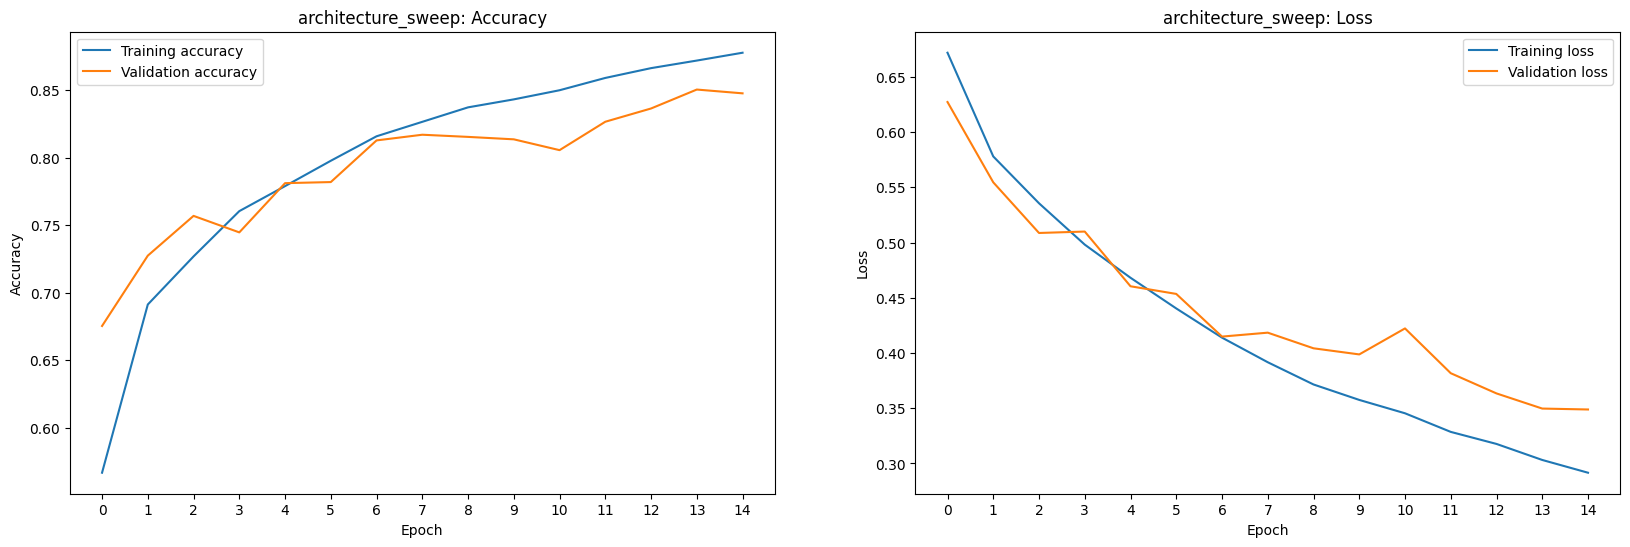

Current best validation accuracy:  0.8504204750061035
Testing architecture config (trial 3): [{'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Conv2D', 'filters': 32, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Conv2D', 'filters': 16, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 256, 'activation': 'tanh'}, {'type': 'Dense', 'units': 512, 'activation': 'tanh'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 85, 85, 16)       0         
 2D)          

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 29s 45ms/step - loss: 0.6213 - acc: 0.6387 - val_loss: 0.5608 - val_acc: 0.7050
Epoch 2/15
625/625 [==============================] - 23s 36ms/step - loss: 0.5097 - acc: 0.7464 - val_loss: 0.5053 - val_acc: 0.7361
Epoch 3/15
625/625 [==============================] - 24s 37ms/step - loss: 0.4475 - acc: 0.7924 - val_loss: 0.4433 - val_acc: 0.7909
Epoch 4/15
625/625 [==============================] - 24s 39ms/step - loss: 0.4094 - acc: 0.8145 - val_loss: 0.4295 - val_acc: 0.8082
Epoch 5/15
625/625 [==============================] - 22s 35ms/step - loss: 0.3807 - acc: 0.8296 - val_loss: 0.4330 - val_acc: 0.8092
Epoch 6/15
625/625 [==============================] - 23s 36ms/step - loss: 0.3484 - acc: 0.8466 - val_loss: 0.3844 - val_acc: 0.8260
Epoch 7/15
625/625 [==============================] - 24s 39ms/step - loss: 0.3229 - acc: 0.8597 - val_loss: 0.3722 - val_acc: 0.8412
Epoch 8/15
625/625 [==============================] - 23s 36ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


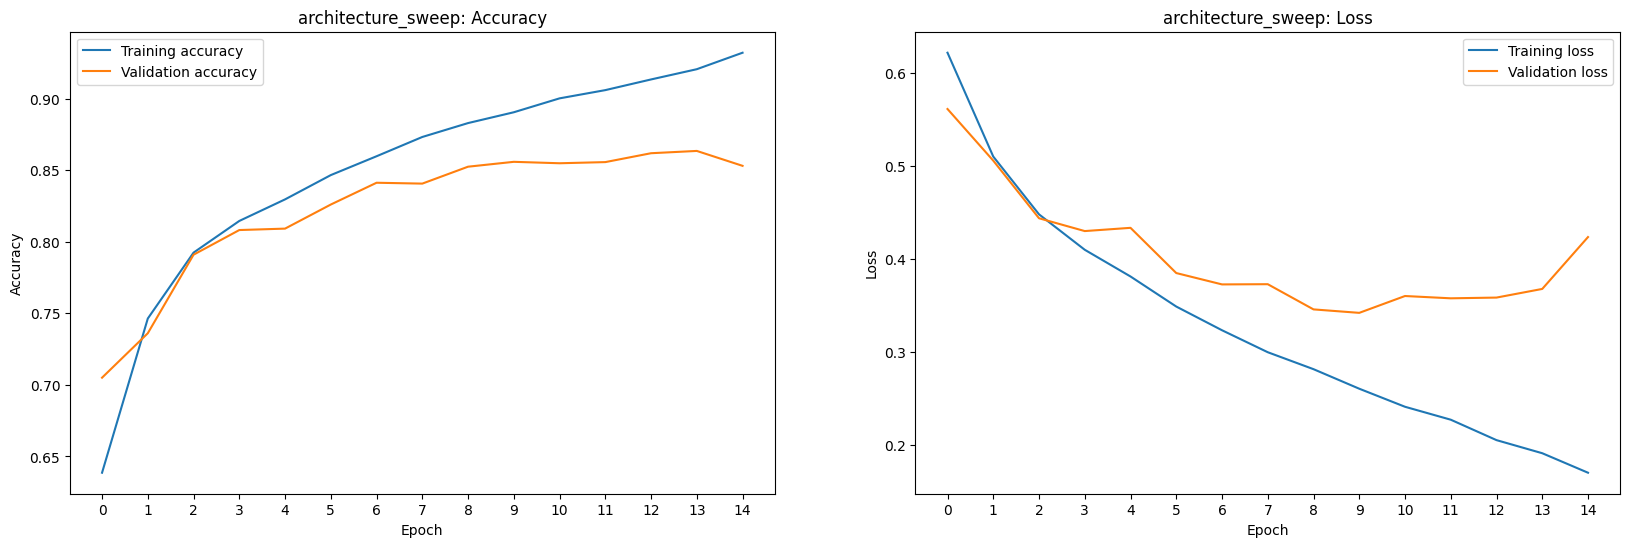

Current best validation accuracy:  0.8634361028671265
Testing architecture config (trial 4): [{'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.8697823572190829}, {'type': 'Conv2D', 'filters': 128, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Conv2D', 'filters': 128, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Conv2D', 'filters': 32, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_8 (MaxPooling  (Non

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 51s 78ms/step - loss: 0.6876 - acc: 0.5586 - val_loss: 0.6793 - val_acc: 0.6129
Epoch 2/15
625/625 [==============================] - 48s 76ms/step - loss: 0.6277 - acc: 0.6377 - val_loss: 0.6503 - val_acc: 0.6221
Epoch 3/15
625/625 [==============================] - 46s 73ms/step - loss: 0.5563 - acc: 0.7176 - val_loss: 0.6227 - val_acc: 0.6620
Epoch 4/15
625/625 [==============================] - 45s 71ms/step - loss: 0.5129 - acc: 0.7503 - val_loss: 0.5933 - val_acc: 0.6686
Epoch 5/15
625/625 [==============================] - 48s 76ms/step - loss: 0.4797 - acc: 0.7733 - val_loss: 0.6093 - val_acc: 0.6572
Epoch 6/15
625/625 [==============================] - 49s 79ms/step - loss: 0.4520 - acc: 0.7909 - val_loss: 0.5481 - val_acc: 0.7135
Epoch 7/15
625/625 [==============================] - 48s 77ms/step - loss: 0.4286 - acc: 0.8071 - val_loss: 0.5383 - val_acc: 0.7277
Epoch 8/15
625/625 [==============================] - 47s 76ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


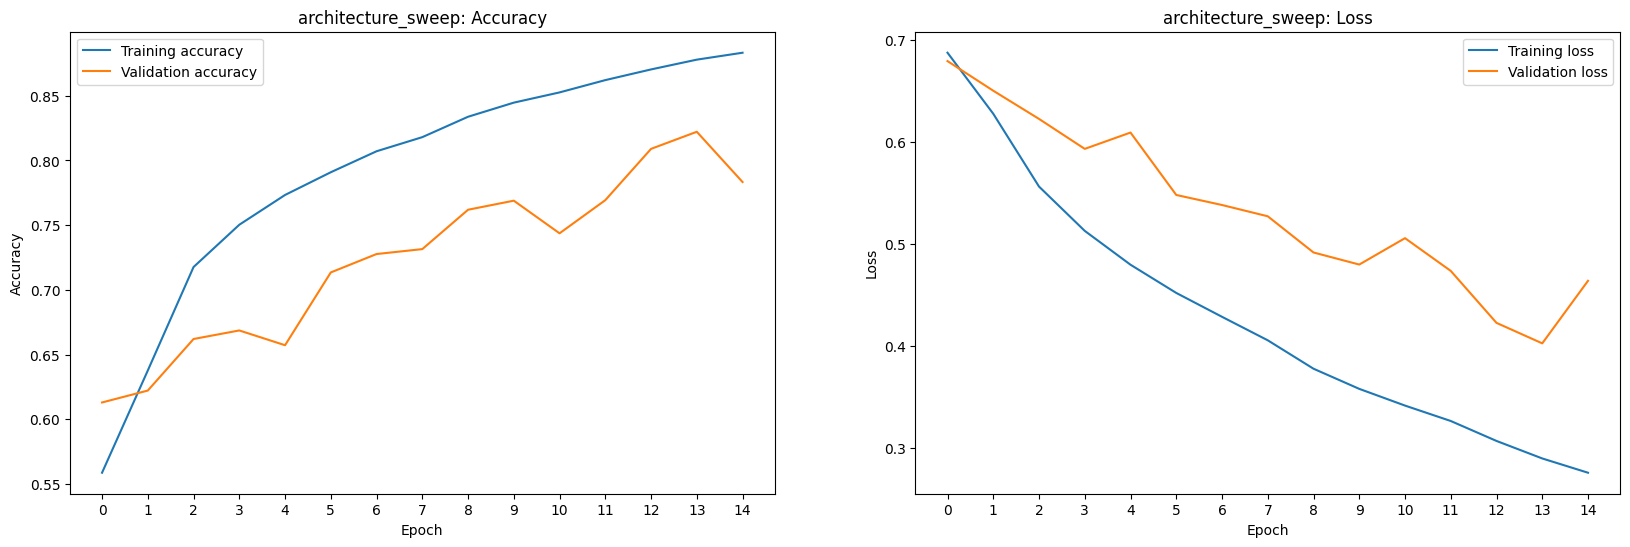

Current best validation accuracy:  0.8634361028671265
Testing architecture config (trial 5): [{'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.3498461245618681}, {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Conv2D', 'filters': 128, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.27234989486146316}, {'type': 'Conv2D', 'filters': 128, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 256, 'activation': 'tanh'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 256, 256, 32)      896   

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 42s 65ms/step - loss: 0.6905 - acc: 0.5570 - val_loss: 0.6579 - val_acc: 0.6147
Epoch 2/15
625/625 [==============================] - 43s 68ms/step - loss: 0.5852 - acc: 0.6884 - val_loss: 0.5755 - val_acc: 0.6950
Epoch 3/15
625/625 [==============================] - 42s 67ms/step - loss: 0.4923 - acc: 0.7627 - val_loss: 0.4936 - val_acc: 0.7545
Epoch 4/15
625/625 [==============================] - 41s 66ms/step - loss: 0.4385 - acc: 0.7977 - val_loss: 0.4492 - val_acc: 0.7845
Epoch 5/15
625/625 [==============================] - 42s 67ms/step - loss: 0.3946 - acc: 0.8229 - val_loss: 0.3881 - val_acc: 0.8200
Epoch 6/15
625/625 [==============================] - 39s 61ms/step - loss: 0.3585 - acc: 0.8408 - val_loss: 0.3735 - val_acc: 0.8372
Epoch 7/15
625/625 [==============================] - 40s 64ms/step - loss: 0.3214 - acc: 0.8569 - val_loss: 0.3530 - val_acc: 0.8462
Epoch 8/15
625/625 [==============================] - 40s 64ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


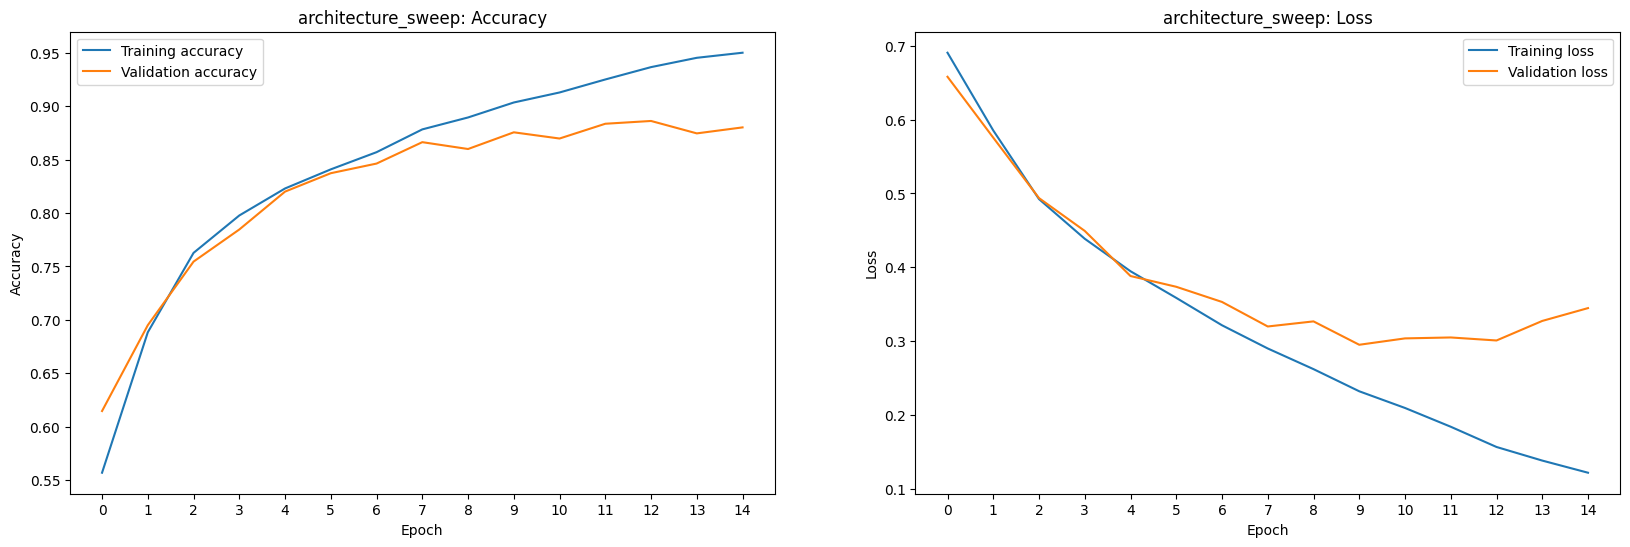

Current best validation accuracy:  0.886063277721405
Testing architecture config (trial 6): [{'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Conv2D', 'filters': 128, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Dropout', 'rate': 0.4988057434740678}, {'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.8383942396258244}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 256, 256, 64)      1792      
                                                     

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 36s 55ms/step - loss: 0.6699 - acc: 0.5683 - val_loss: 0.6399 - val_acc: 0.6123
Epoch 2/15
625/625 [==============================] - 39s 63ms/step - loss: 0.6338 - acc: 0.6257 - val_loss: 0.6118 - val_acc: 0.6640
Epoch 3/15
625/625 [==============================] - 34s 54ms/step - loss: 0.5954 - acc: 0.6756 - val_loss: 0.5418 - val_acc: 0.7355
Epoch 4/15
625/625 [==============================] - 38s 60ms/step - loss: 0.5594 - acc: 0.7100 - val_loss: 0.5229 - val_acc: 0.7457
Epoch 5/15
625/625 [==============================] - 41s 65ms/step - loss: 0.5382 - acc: 0.7315 - val_loss: 0.5253 - val_acc: 0.7415
Epoch 6/15
625/625 [==============================] - 38s 60ms/step - loss: 0.5203 - acc: 0.7477 - val_loss: 0.4792 - val_acc: 0.7719
Epoch 7/15
625/625 [==============================] - 40s 64ms/step - loss: 0.5028 - acc: 0.7592 - val_loss: 0.4766 - val_acc: 0.7795
Epoch 8/15
625/625 [==============================] - 35s 56ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


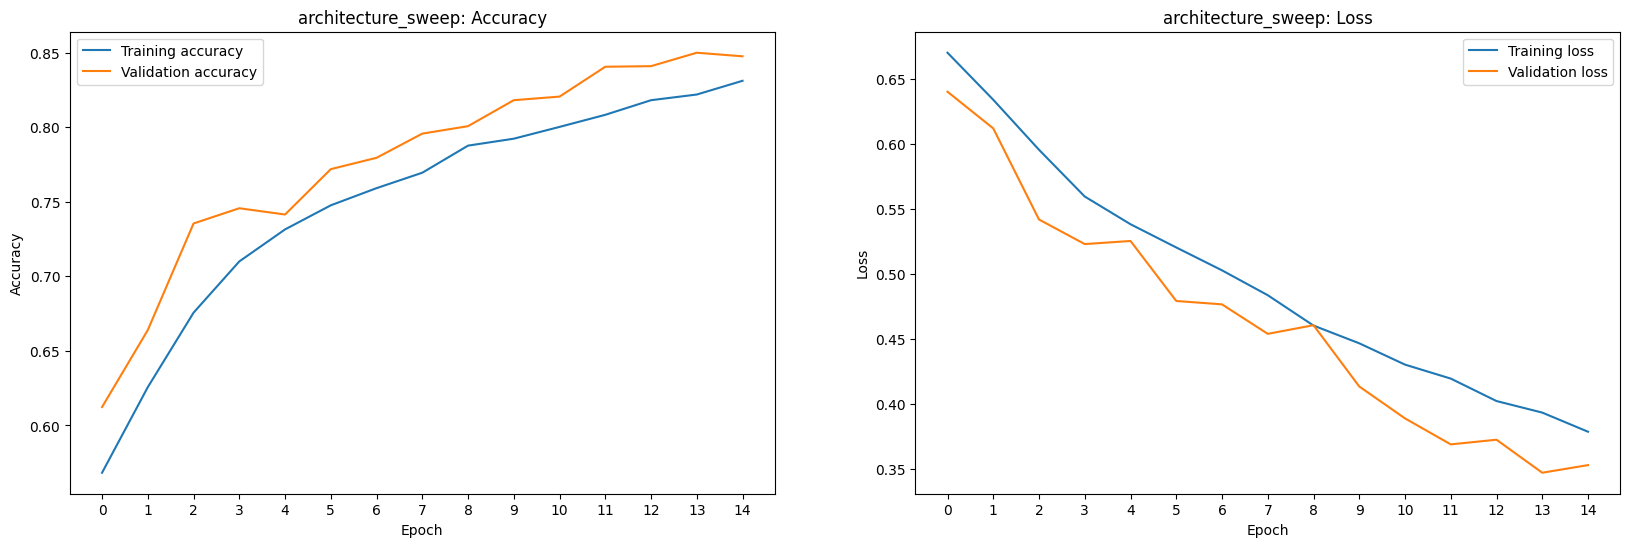

Current best validation accuracy:  0.886063277721405
Testing architecture config (trial 7): [{'type': 'Conv2D', 'filters': 16, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Conv2D', 'filters': 32, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Dropout', 'rate': 0.4898443887449945}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 256, 256, 16)      1216      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 28s 43ms/step - loss: 0.6413 - acc: 0.6212 - val_loss: 0.5608 - val_acc: 0.7271
Epoch 2/15
625/625 [==============================] - 22s 35ms/step - loss: 0.5629 - acc: 0.7121 - val_loss: 0.5148 - val_acc: 0.7577
Epoch 3/15
625/625 [==============================] - 22s 35ms/step - loss: 0.5101 - acc: 0.7523 - val_loss: 0.4755 - val_acc: 0.7749
Epoch 4/15
625/625 [==============================] - 26s 42ms/step - loss: 0.4753 - acc: 0.7731 - val_loss: 0.4466 - val_acc: 0.7952
Epoch 5/15
625/625 [==============================] - 30s 47ms/step - loss: 0.4391 - acc: 0.7992 - val_loss: 0.4244 - val_acc: 0.8008
Epoch 6/15
625/625 [==============================] - 27s 42ms/step - loss: 0.4153 - acc: 0.8111 - val_loss: 0.3925 - val_acc: 0.8272
Epoch 7/15
625/625 [==============================] - 23s 36ms/step - loss: 0.3860 - acc: 0.8278 - val_loss: 0.3813 - val_acc: 0.8318
Epoch 8/15
625/625 [==============================] - 24s 39ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


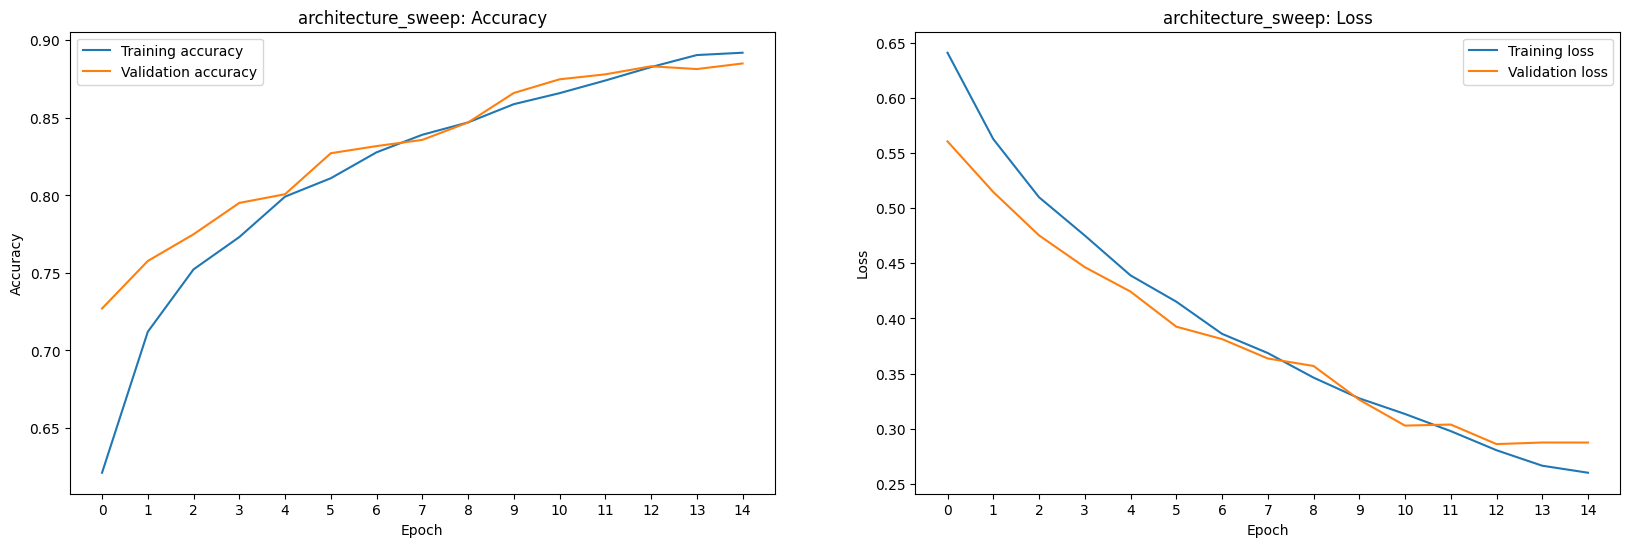

Current best validation accuracy:  0.886063277721405
Testing architecture config (trial 8): [{'type': 'Conv2D', 'filters': 64, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Conv2D', 'filters': 128, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 64, 'activation': 'sigmoid'}, {'type': 'Dense', 'units': 64, 'activation': 'tanh'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 256, 256, 64)      4864      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 85, 85, 64)       0         
 g2D)                                                            
                                                    

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 53s 82ms/step - loss: 0.5754 - acc: 0.6902 - val_loss: 0.4793 - val_acc: 0.7699
Epoch 2/15
625/625 [==============================] - 43s 69ms/step - loss: 0.4518 - acc: 0.7891 - val_loss: 0.4341 - val_acc: 0.7982
Epoch 3/15
625/625 [==============================] - 42s 67ms/step - loss: 0.3757 - acc: 0.8314 - val_loss: 0.4215 - val_acc: 0.8060
Epoch 4/15
625/625 [==============================] - 40s 64ms/step - loss: 0.3110 - acc: 0.8664 - val_loss: 0.4016 - val_acc: 0.8250
Epoch 5/15
625/625 [==============================] - 38s 61ms/step - loss: 0.2435 - acc: 0.9006 - val_loss: 0.4140 - val_acc: 0.8230
Epoch 6/15
625/625 [==============================] - 39s 61ms/step - loss: 0.1800 - acc: 0.9299 - val_loss: 0.4389 - val_acc: 0.8240
Epoch 7/15
625/625 [==============================] - 41s 65ms/step - loss: 0.1141 - acc: 0.9578 - val_loss: 0.5313 - val_acc: 0.8268
Epoch 8/15
625/625 [==============================] - 40s 63ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


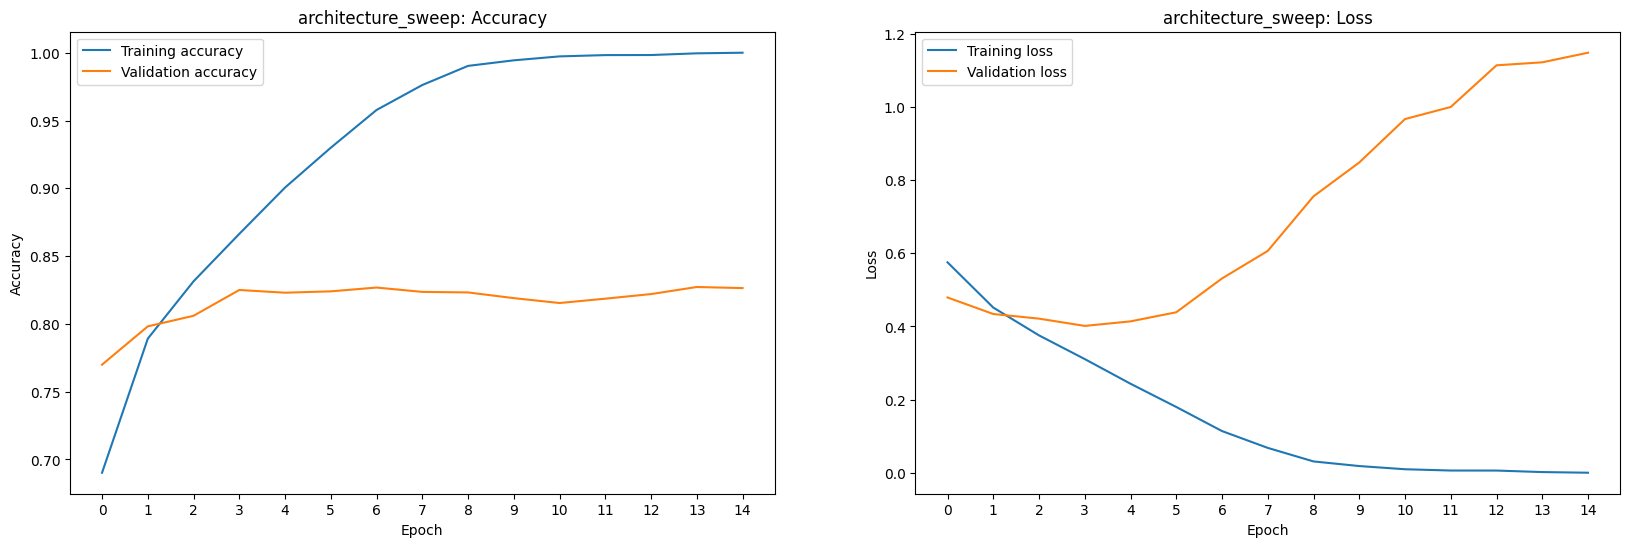

Current best validation accuracy:  0.886063277721405
Testing architecture config (trial 9): [{'type': 'Conv2D', 'filters': 128, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Dropout', 'rate': 0.18252703303038542}, {'type': 'Conv2D', 'filters': 64, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 256, 'activation': 'tanh'}, {'type': 'Dense', 'units': 64, 'activation': 'tanh'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 256, 256, 128)     3584      
                                                                 
 max_pooling2d_26 (MaxPoolin  (None, 85, 85, 128)      0         
 g2D)                                                            
    

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 63s 98ms/step - loss: 0.7189 - acc: 0.4990 - val_loss: 0.6939 - val_acc: 0.5000
Epoch 2/15
625/625 [==============================] - 60s 95ms/step - loss: 0.6937 - acc: 0.5046 - val_loss: 0.6940 - val_acc: 0.5000
Epoch 3/15
625/625 [==============================] - 58s 92ms/step - loss: 0.6939 - acc: 0.4968 - val_loss: 0.6951 - val_acc: 0.5000
Epoch 4/15
625/625 [==============================] - 59s 94ms/step - loss: 0.6936 - acc: 0.4974 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/15
625/625 [==============================] - 60s 96ms/step - loss: 0.6940 - acc: 0.4966 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/15
625/625 [==============================] - 58s 93ms/step - loss: 0.6937 - acc: 0.5001 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 7/15
625/625 [==============================] - 59s 95ms/step - loss: 0.6939 - acc: 0.5011 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 8/15
625/625 [==============================] - 61s 97ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


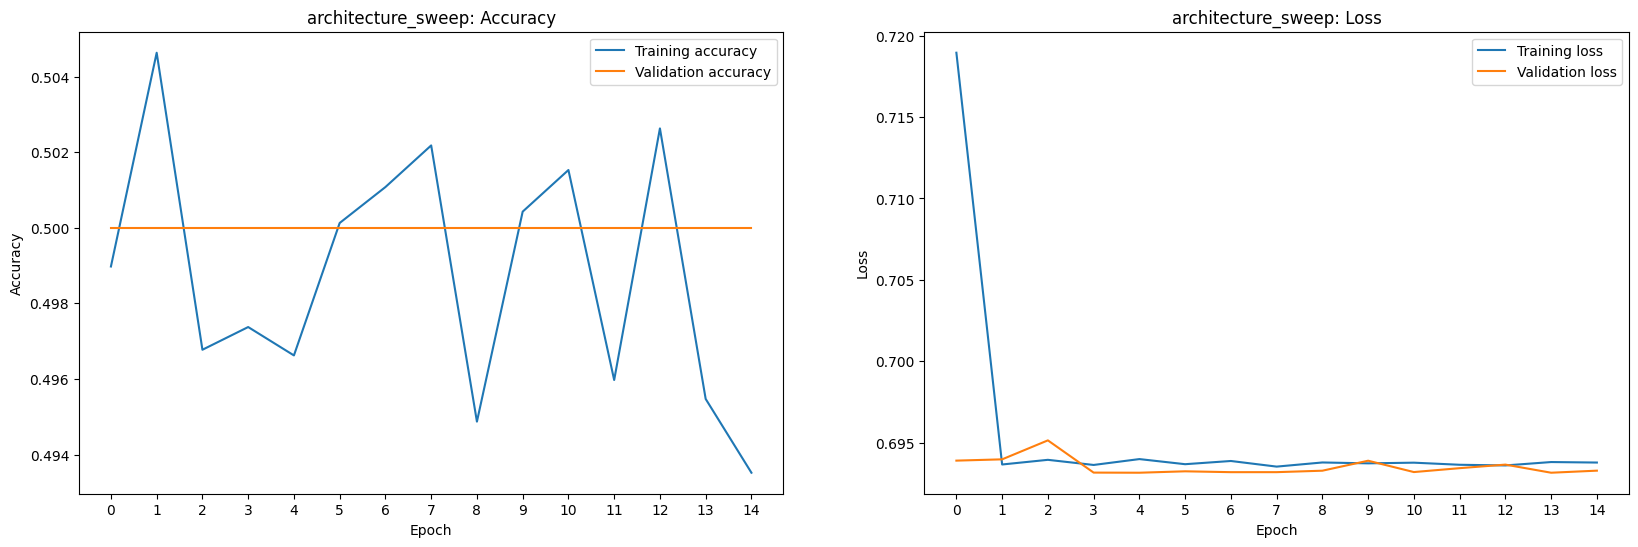

Current best validation accuracy:  0.886063277721405
Testing architecture config (trial 10): [{'type': 'Conv2D', 'filters': 128, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.7206409402678655}, {'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 64, 'activation': 'relu'}, {'type': 'Dense', 'units': 128, 'activation': 'relu'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_28 (Conv2D)          (None, 256, 256, 128)     9728      
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 128, 128, 128)    0         
 g2D)                                                            
    

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 73s 114ms/step - loss: 0.6827 - acc: 0.5479 - val_loss: 0.6736 - val_acc: 0.5689
Epoch 2/15
625/625 [==============================] - 70s 111ms/step - loss: 0.6058 - acc: 0.6686 - val_loss: 0.6173 - val_acc: 0.6612
Epoch 3/15
625/625 [==============================] - 72s 115ms/step - loss: 0.5473 - acc: 0.7216 - val_loss: 0.5422 - val_acc: 0.7207
Epoch 4/15
625/625 [==============================] - 72s 114ms/step - loss: 0.4947 - acc: 0.7591 - val_loss: 0.5402 - val_acc: 0.7401
Epoch 5/15
625/625 [==============================] - 71s 113ms/step - loss: 0.4564 - acc: 0.7807 - val_loss: 0.5338 - val_acc: 0.7395
Epoch 6/15
625/625 [==============================] - 73s 117ms/step - loss: 0.4107 - acc: 0.8103 - val_loss: 0.4977 - val_acc: 0.7615
Epoch 7/15
625/625 [==============================] - 78s 124ms/step - loss: 0.3591 - acc: 0.8387 - val_loss: 0.5032 - val_acc: 0.7555
Epoch 8/15
625/625 [==============================] - 74s 118ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


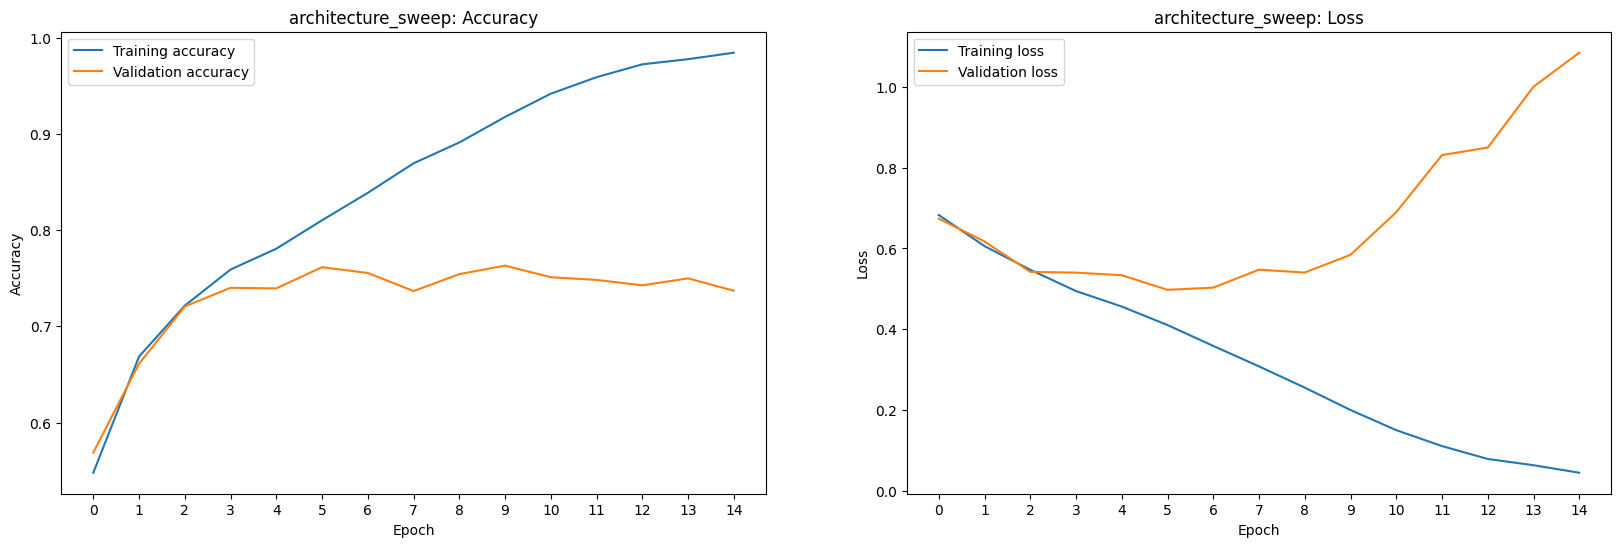

Current best validation accuracy:  0.886063277721405
Testing architecture config (trial 11): [{'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Conv2D', 'filters': 64, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Dropout', 'rate': 0.8148786202624259}, {'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Conv2D', 'filters': 128, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_30 (MaxPoolin  (Non

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 38s 58ms/step - loss: 0.6687 - acc: 0.5813 - val_loss: 0.6479 - val_acc: 0.6376
Epoch 2/15
625/625 [==============================] - 36s 57ms/step - loss: 0.5925 - acc: 0.6873 - val_loss: 0.6114 - val_acc: 0.6444
Epoch 3/15
625/625 [==============================] - 39s 61ms/step - loss: 0.5269 - acc: 0.7412 - val_loss: 0.5592 - val_acc: 0.6966
Epoch 4/15
625/625 [==============================] - 35s 56ms/step - loss: 0.4899 - acc: 0.7647 - val_loss: 0.5091 - val_acc: 0.7465
Epoch 5/15
625/625 [==============================] - 35s 56ms/step - loss: 0.4611 - acc: 0.7819 - val_loss: 0.4946 - val_acc: 0.7503
Epoch 6/15
625/625 [==============================] - 34s 54ms/step - loss: 0.4363 - acc: 0.7946 - val_loss: 0.4299 - val_acc: 0.8054
Epoch 7/15
625/625 [==============================] - 39s 61ms/step - loss: 0.4142 - acc: 0.8112 - val_loss: 0.4029 - val_acc: 0.8248
Epoch 8/15
625/625 [==============================] - 39s 62ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


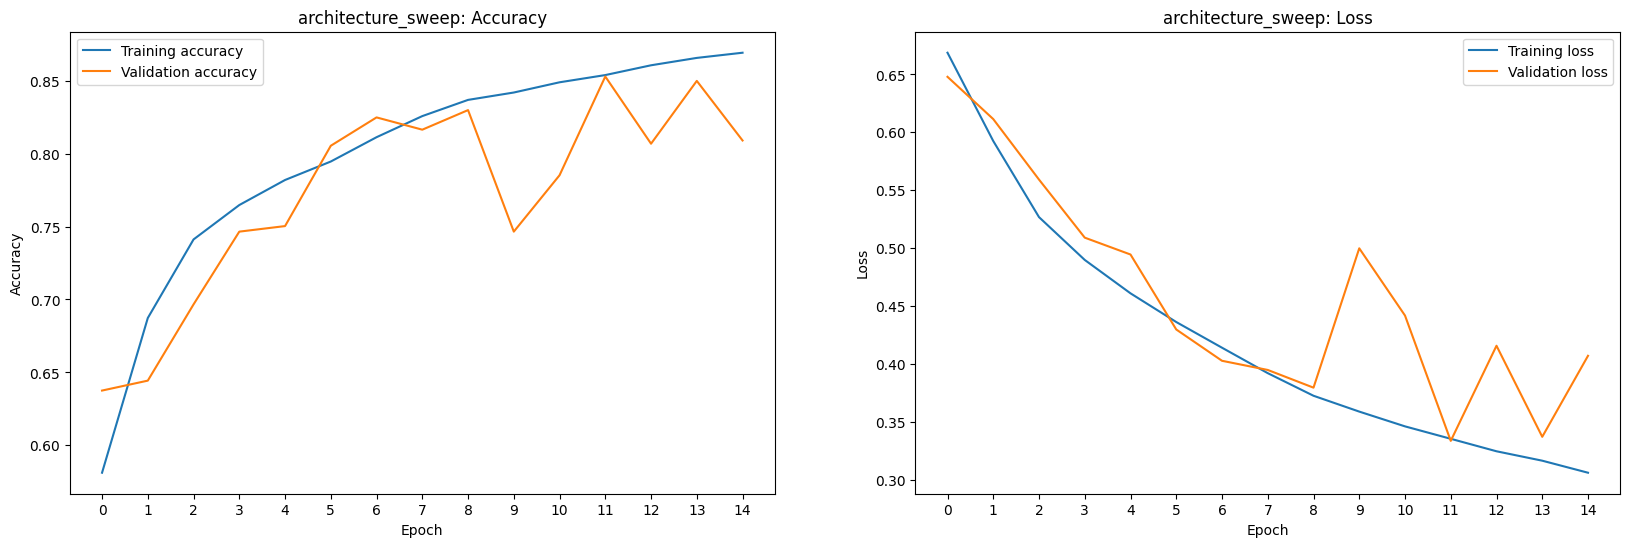

Current best validation accuracy:  0.886063277721405
Testing architecture config (trial 12): [{'type': 'Conv2D', 'filters': 16, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Dropout', 'rate': 0.6895079918922177}, {'type': 'Conv2D', 'filters': 16, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.2798550775032325}, {'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 128, 'activation': 'relu'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_34 (Conv2D)          (None, 256, 256, 16)      1216    

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 26s 40ms/step - loss: 0.6717 - acc: 0.5766 - val_loss: 0.6701 - val_acc: 0.5841
Epoch 2/15
625/625 [==============================] - 25s 39ms/step - loss: 0.6120 - acc: 0.6579 - val_loss: 0.6627 - val_acc: 0.5731
Epoch 3/15
625/625 [==============================] - 25s 40ms/step - loss: 0.5538 - acc: 0.7129 - val_loss: 0.5964 - val_acc: 0.6598
Epoch 4/15
625/625 [==============================] - 23s 36ms/step - loss: 0.5235 - acc: 0.7386 - val_loss: 0.6288 - val_acc: 0.6304
Epoch 5/15
625/625 [==============================] - 23s 36ms/step - loss: 0.5013 - acc: 0.7534 - val_loss: 0.7296 - val_acc: 0.5959
Epoch 6/15
625/625 [==============================] - 28s 45ms/step - loss: 0.4853 - acc: 0.7645 - val_loss: 0.5245 - val_acc: 0.7239
Epoch 7/15
625/625 [==============================] - 22s 36ms/step - loss: 0.4647 - acc: 0.7764 - val_loss: 0.6464 - val_acc: 0.6674
Epoch 8/15
625/625 [==============================] - 23s 36ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


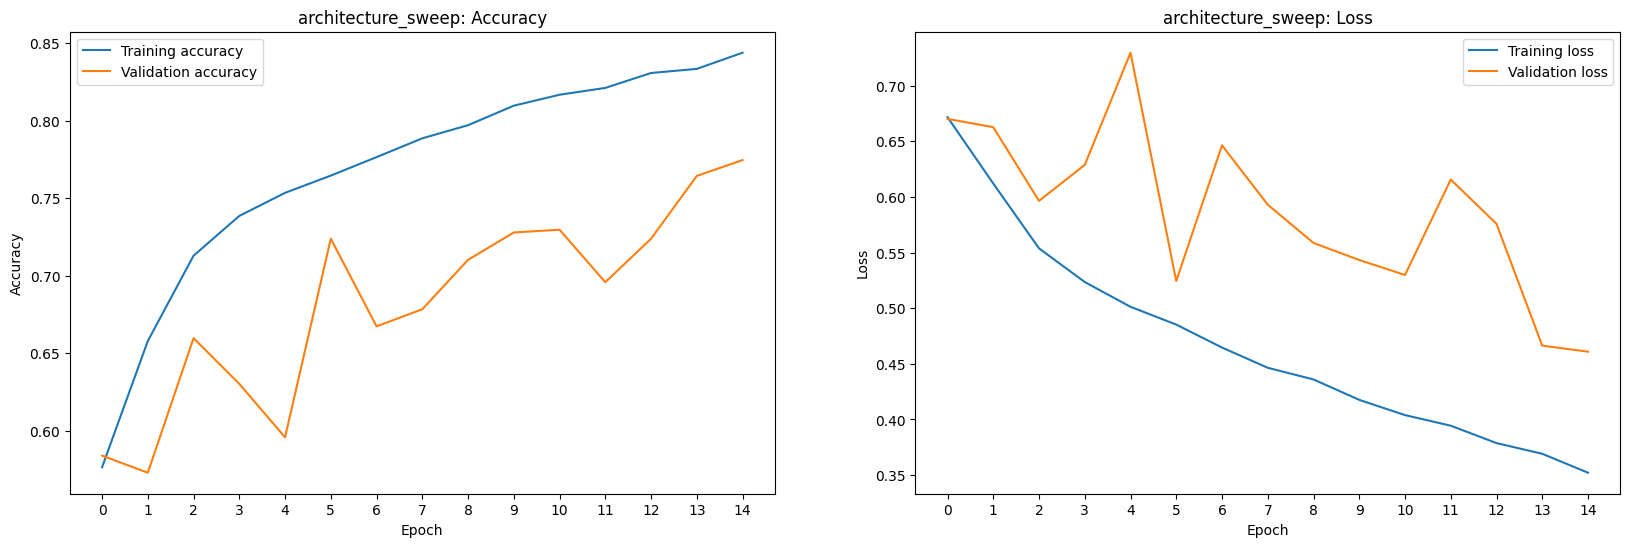

Current best validation accuracy:  0.886063277721405
Testing architecture config (trial 13): [{'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Dropout', 'rate': 0.7827175523137688}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 256, 'activation': 'tanh'}, {'type': 'Dense', 'units': 512, 'activation': 'sigmoid'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_38 (Conv2D)          (None, 256, 256, 16)      448       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 85, 85, 16)       0         
 g2D)                                                            
                                                                 
 dropout_13 (Dropout)        (None, 85,

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 24s 37ms/step - loss: 0.6452 - acc: 0.6068 - val_loss: 0.5642 - val_acc: 0.7056
Epoch 2/15
625/625 [==============================] - 25s 39ms/step - loss: 0.5556 - acc: 0.7093 - val_loss: 0.5552 - val_acc: 0.7135
Epoch 3/15
625/625 [==============================] - 25s 39ms/step - loss: 0.5055 - acc: 0.7492 - val_loss: 0.5133 - val_acc: 0.7387
Epoch 4/15
625/625 [==============================] - 23s 36ms/step - loss: 0.4588 - acc: 0.7753 - val_loss: 0.5413 - val_acc: 0.7213
Epoch 5/15
625/625 [==============================] - 25s 40ms/step - loss: 0.4236 - acc: 0.8020 - val_loss: 0.5227 - val_acc: 0.7395
Epoch 6/15
625/625 [==============================] - 23s 36ms/step - loss: 0.3839 - acc: 0.8241 - val_loss: 0.5009 - val_acc: 0.7497
Epoch 7/15
625/625 [==============================] - 23s 36ms/step - loss: 0.3604 - acc: 0.8373 - val_loss: 0.5177 - val_acc: 0.7489
Epoch 8/15
625/625 [==============================] - 23s 37ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


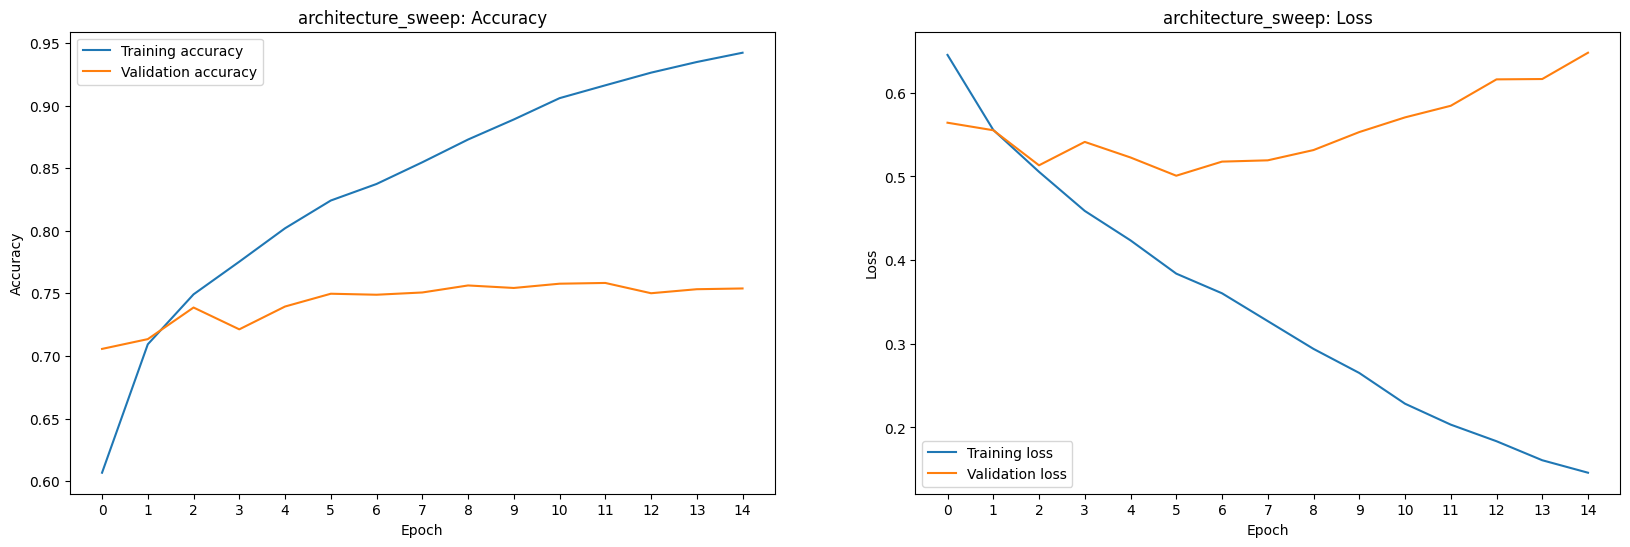

Current best validation accuracy:  0.886063277721405
Testing architecture config (trial 14): [{'type': 'Conv2D', 'filters': 128, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Conv2D', 'filters': 64, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Dropout', 'rate': 0.4821130282422229}, {'type': 'Conv2D', 'filters': 128, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 256, 256, 128)     3584      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 128, 128, 128)    0         
 g2D)                                                            
      

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 70s 108ms/step - loss: 0.6854 - acc: 0.5497 - val_loss: 0.6551 - val_acc: 0.6047
Epoch 2/15
625/625 [==============================] - 67s 106ms/step - loss: 0.6069 - acc: 0.6674 - val_loss: 0.5851 - val_acc: 0.6922
Epoch 3/15
625/625 [==============================] - 67s 108ms/step - loss: 0.5320 - acc: 0.7315 - val_loss: 0.5230 - val_acc: 0.7379
Epoch 4/15
625/625 [==============================] - 67s 107ms/step - loss: 0.4727 - acc: 0.7775 - val_loss: 0.4778 - val_acc: 0.7755
Epoch 5/15
625/625 [==============================] - 67s 106ms/step - loss: 0.4345 - acc: 0.7985 - val_loss: 0.4573 - val_acc: 0.7823
Epoch 6/15
625/625 [==============================] - 65s 104ms/step - loss: 0.4068 - acc: 0.8186 - val_loss: 0.4241 - val_acc: 0.8048
Epoch 7/15
625/625 [==============================] - 11784s 19s/step - loss: 0.3837 - acc: 0.8325 - val_loss: 0.3877 - val_acc: 0.8362
Epoch 8/15
625/625 [==============================] - 68s 109ms/s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


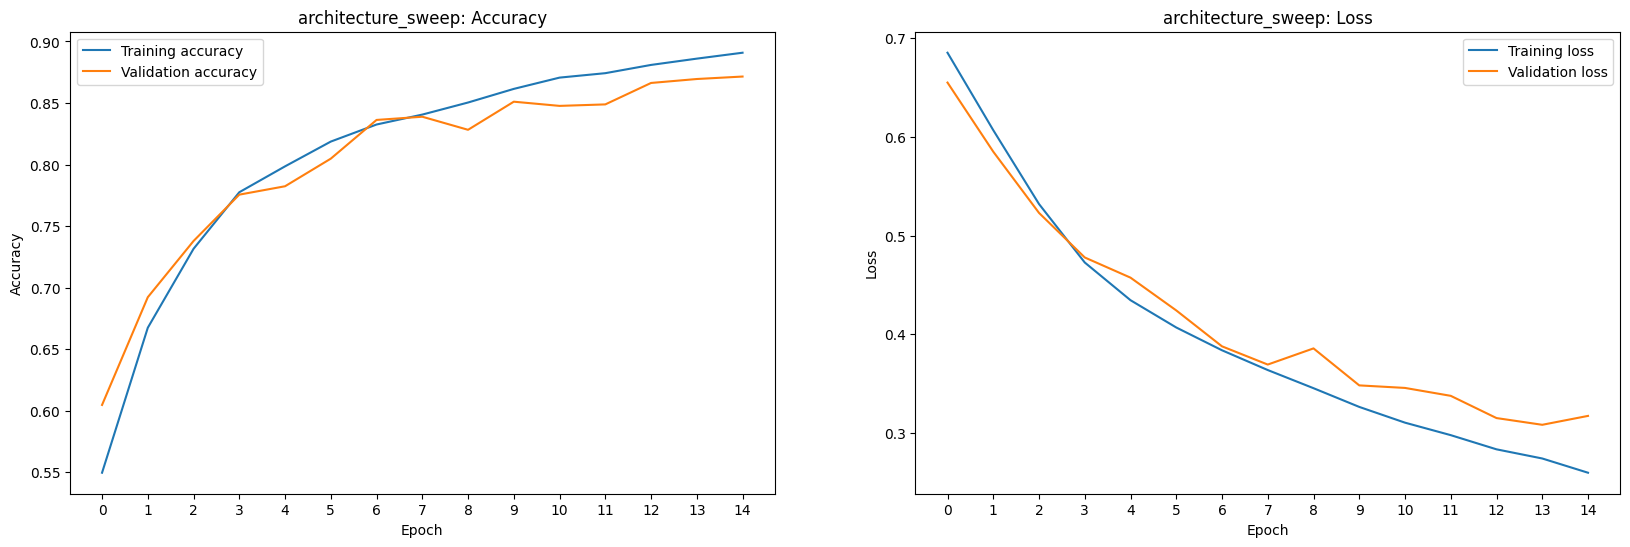

Current best validation accuracy:  0.886063277721405
Testing architecture config (trial 15): [{'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 128, 'activation': 'sigmoid'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_42 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_42 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 flatten_14 (Flatten)        (None, 524288)            0         
                                                                 
 dense_28 (

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 31s 49ms/step - loss: 0.7626 - acc: 0.5881 - val_loss: 0.6160 - val_acc: 0.6546
Epoch 2/15
625/625 [==============================] - 32s 51ms/step - loss: 0.5617 - acc: 0.7079 - val_loss: 0.5254 - val_acc: 0.7343
Epoch 3/15
625/625 [==============================] - 29s 46ms/step - loss: 0.4591 - acc: 0.7848 - val_loss: 0.5157 - val_acc: 0.7391
Epoch 4/15
625/625 [==============================] - 33s 53ms/step - loss: 0.3529 - acc: 0.8543 - val_loss: 0.5620 - val_acc: 0.7219
Epoch 5/15
625/625 [==============================] - 32s 52ms/step - loss: 0.2424 - acc: 0.9133 - val_loss: 0.5215 - val_acc: 0.7547
Epoch 6/15
625/625 [==============================] - 29s 46ms/step - loss: 0.1519 - acc: 0.9558 - val_loss: 0.5737 - val_acc: 0.7521
Epoch 7/15
625/625 [==============================] - 32s 52ms/step - loss: 0.0857 - acc: 0.9826 - val_loss: 0.6409 - val_acc: 0.7521
Epoch 8/15
625/625 [==============================] - 30s 47ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


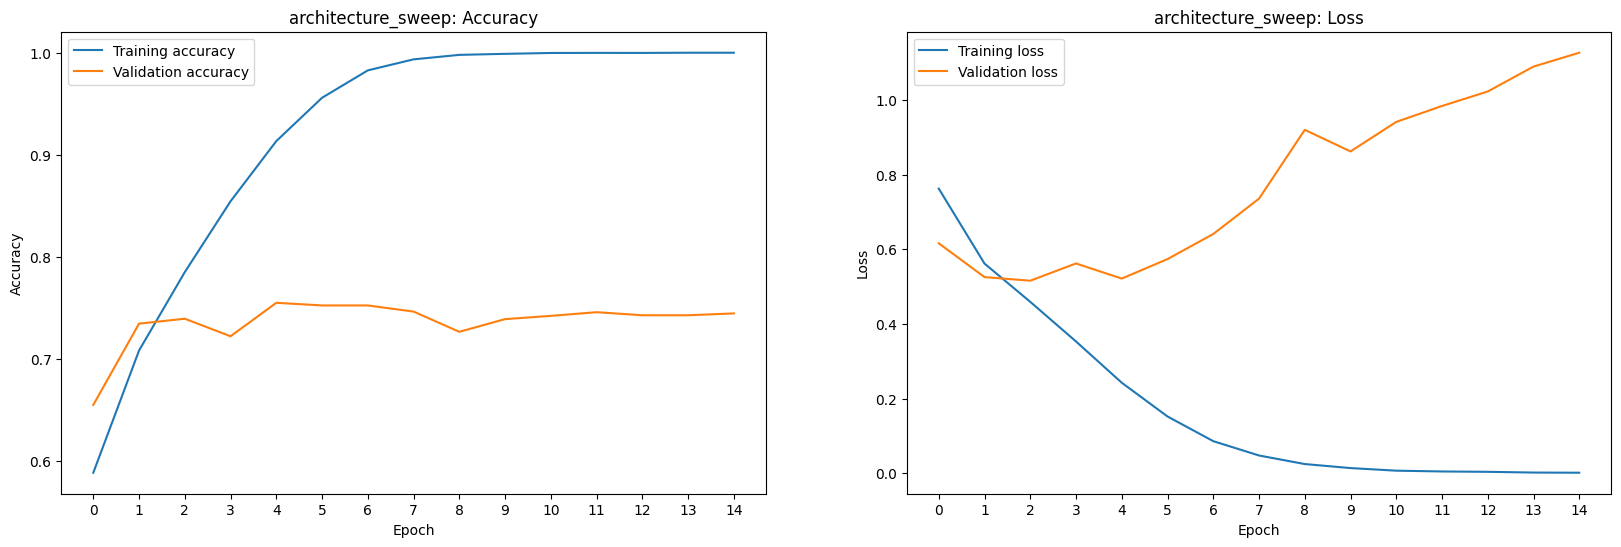

Current best validation accuracy:  0.886063277721405
Testing architecture config (trial 16): [{'type': 'Conv2D', 'filters': 32, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Conv2D', 'filters': 64, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.38271112338695834}, {'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.2910111832058714}, {'type': 'Conv2D', 'filters': 64, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.2985760448907449}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 64, 'activation': 'relu'}, {'type': 'Dense', 'units': 256, 'activation': 'sigmoid'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_15"
_________________________________________________________________
 Layer (type)         

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 37s 57ms/step - loss: 0.6622 - acc: 0.5749 - val_loss: 0.5997 - val_acc: 0.6700
Epoch 2/15
625/625 [==============================] - 33s 52ms/step - loss: 0.5433 - acc: 0.7215 - val_loss: 0.5007 - val_acc: 0.7547
Epoch 3/15
625/625 [==============================] - 34s 54ms/step - loss: 0.4878 - acc: 0.7600 - val_loss: 0.4650 - val_acc: 0.7839
Epoch 4/15
625/625 [==============================] - 34s 54ms/step - loss: 0.4383 - acc: 0.7958 - val_loss: 0.4485 - val_acc: 0.7815
Epoch 5/15
625/625 [==============================] - 32s 51ms/step - loss: 0.3994 - acc: 0.8194 - val_loss: 0.3670 - val_acc: 0.8404
Epoch 6/15
625/625 [==============================] - 34s 54ms/step - loss: 0.3611 - acc: 0.8418 - val_loss: 0.3502 - val_acc: 0.8510
Epoch 7/15
625/625 [==============================] - 38s 60ms/step - loss: 0.3306 - acc: 0.8563 - val_loss: 0.3319 - val_acc: 0.8572
Epoch 8/15
625/625 [==============================] - 37s 58ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


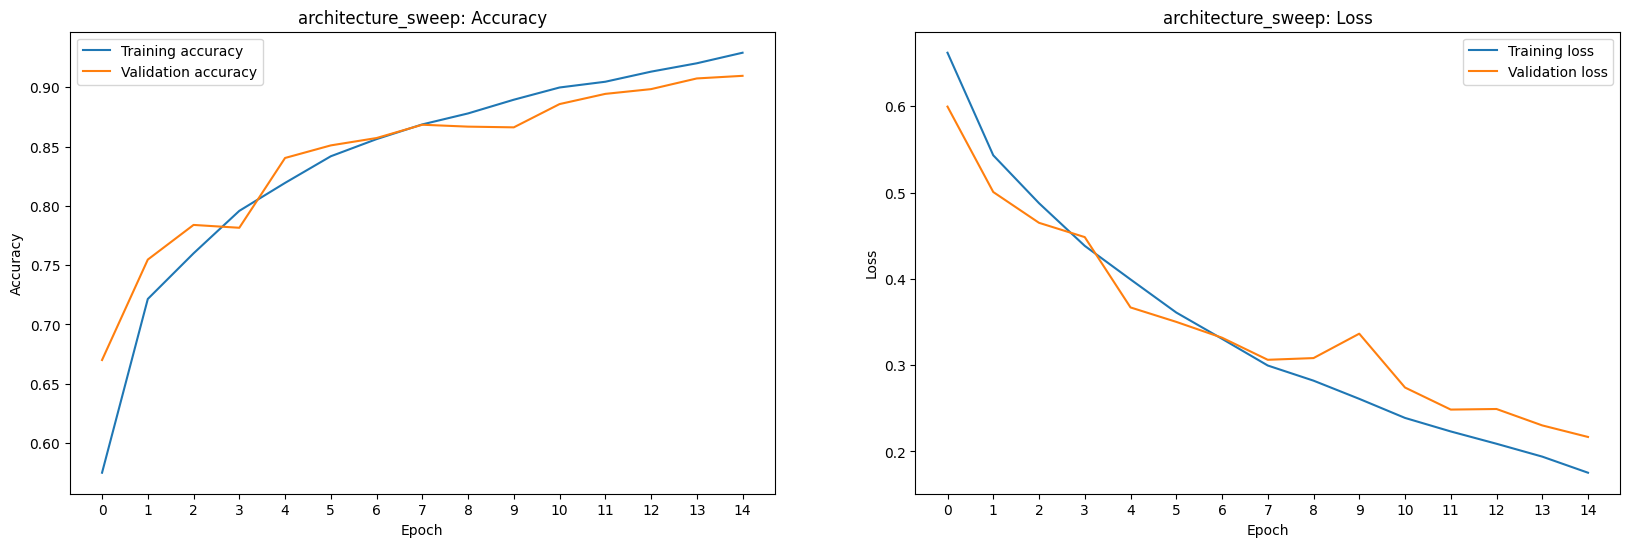

Current best validation accuracy:  0.9096916317939758
Testing architecture config (trial 17): [{'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.31092780965123934}, {'type': 'Conv2D', 'filters': 32, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.781725975073845}, {'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.138528091702696}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 256, 'activation': 'sigmoid'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 256, 256, 16)      448       
                                                  

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 32s 49ms/step - loss: 0.7652 - acc: 0.5607 - val_loss: 0.9612 - val_acc: 0.5000
Epoch 2/15
625/625 [==============================] - 53s 85ms/step - loss: 0.6321 - acc: 0.6283 - val_loss: 1.1952 - val_acc: 0.5002
Epoch 3/15
625/625 [==============================] - 30s 47ms/step - loss: 0.5925 - acc: 0.6717 - val_loss: 0.9808 - val_acc: 0.5200
Epoch 4/15
625/625 [==============================] - 30s 47ms/step - loss: 0.5511 - acc: 0.7105 - val_loss: 0.8067 - val_acc: 0.5603
Epoch 5/15
625/625 [==============================] - 31s 49ms/step - loss: 0.5225 - acc: 0.7340 - val_loss: 0.7262 - val_acc: 0.6055
Epoch 6/15
625/625 [==============================] - 30s 48ms/step - loss: 0.4952 - acc: 0.7515 - val_loss: 0.8051 - val_acc: 0.5989
Epoch 7/15
625/625 [==============================] - 31s 49ms/step - loss: 0.4772 - acc: 0.7638 - val_loss: 0.7122 - val_acc: 0.6526
Epoch 8/15
625/625 [==============================] - 32s 51ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


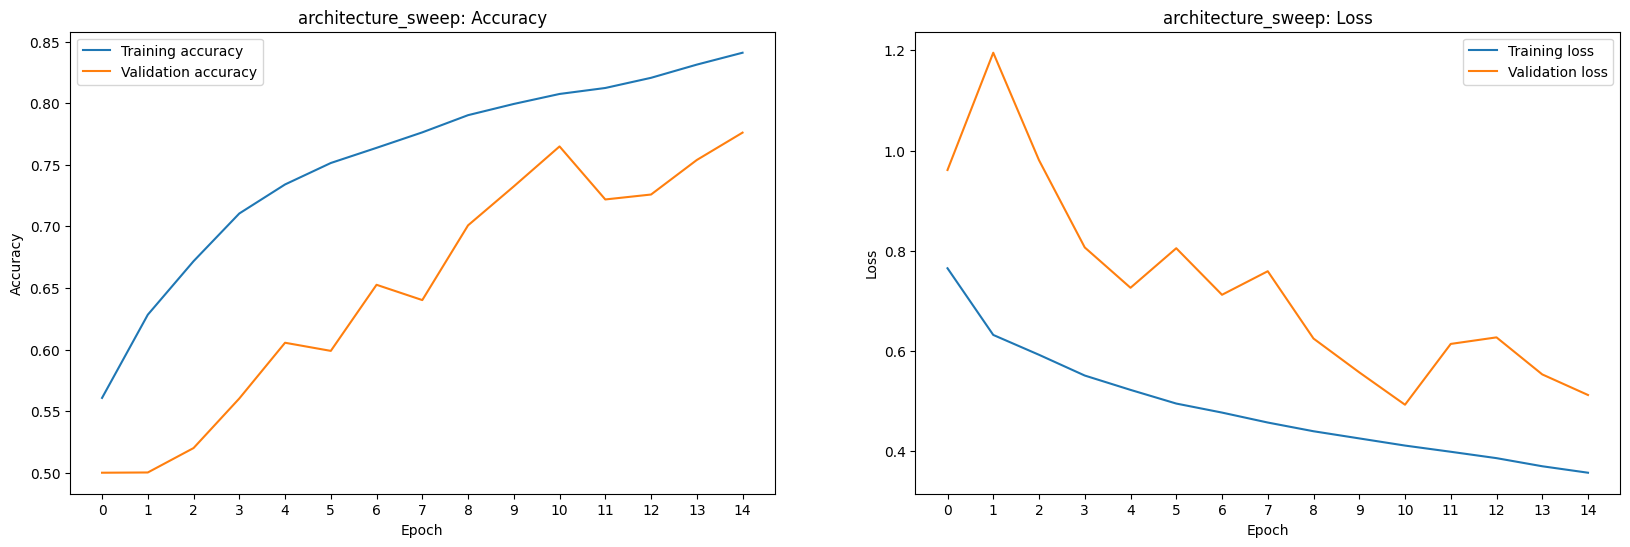

Current best validation accuracy:  0.9096916317939758
Testing architecture config (trial 18): [{'type': 'Conv2D', 'filters': 128, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Dropout', 'rate': 0.8724161150632911}, {'type': 'Conv2D', 'filters': 32, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 128, 'activation': 'sigmoid'}, {'type': 'Dense', 'units': 64, 'activation': 'sigmoid'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_50 (Conv2D)          (None, 256, 256, 128)     9728      
                                                                 
 max_pooling2d_50 (MaxP

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 80s 126ms/step - loss: 0.6667 - acc: 0.5814 - val_loss: 0.6079 - val_acc: 0.6870
Epoch 2/15
625/625 [==============================] - 76s 121ms/step - loss: 0.5677 - acc: 0.7079 - val_loss: 0.5337 - val_acc: 0.7345
Epoch 3/15
625/625 [==============================] - 79s 126ms/step - loss: 0.5077 - acc: 0.7512 - val_loss: 0.4958 - val_acc: 0.7581
Epoch 4/15
625/625 [==============================] - 76s 122ms/step - loss: 0.4633 - acc: 0.7836 - val_loss: 0.4765 - val_acc: 0.7719
Epoch 5/15
625/625 [==============================] - 77s 123ms/step - loss: 0.4262 - acc: 0.8049 - val_loss: 0.5080 - val_acc: 0.7605
Epoch 6/15
625/625 [==============================] - 77s 123ms/step - loss: 0.3907 - acc: 0.8270 - val_loss: 0.4737 - val_acc: 0.7745
Epoch 7/15
625/625 [==============================] - 75s 119ms/step - loss: 0.3580 - acc: 0.8439 - val_loss: 0.4633 - val_acc: 0.7825
Epoch 8/15
625/625 [==============================] - 75s 119ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


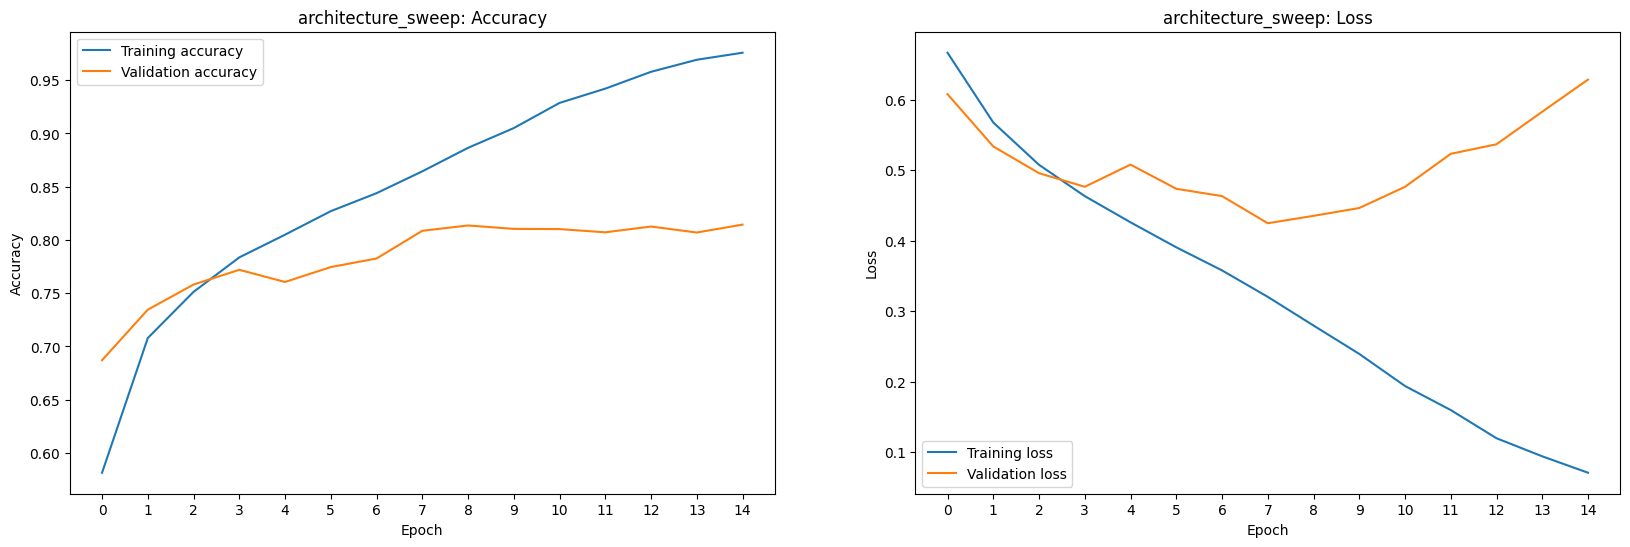

Current best validation accuracy:  0.9096916317939758
Testing architecture config (trial 19): [{'type': 'Conv2D', 'filters': 32, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Conv2D', 'filters': 128, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_53 (Conv2D)          (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d_53 (MaxPoolin  (None, 128, 128, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_54 (Conv2D)          (None, 128, 128, 128)     102528    
                            

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 41s 64ms/step - loss: 0.7012 - acc: 0.5853 - val_loss: 0.6187 - val_acc: 0.6686
Epoch 2/15
625/625 [==============================] - 44s 71ms/step - loss: 0.5747 - acc: 0.7045 - val_loss: 0.5293 - val_acc: 0.7347
Epoch 3/15
625/625 [==============================] - 42s 67ms/step - loss: 0.4962 - acc: 0.7607 - val_loss: 0.5127 - val_acc: 0.7495
Epoch 4/15
625/625 [==============================] - 40s 64ms/step - loss: 0.4415 - acc: 0.7950 - val_loss: 0.5142 - val_acc: 0.7645
Epoch 5/15
625/625 [==============================] - 42s 67ms/step - loss: 0.3858 - acc: 0.8259 - val_loss: 0.4705 - val_acc: 0.7817
Epoch 6/15
625/625 [==============================] - 42s 67ms/step - loss: 0.3339 - acc: 0.8566 - val_loss: 0.4910 - val_acc: 0.7853
Epoch 7/15
625/625 [==============================] - 42s 67ms/step - loss: 0.2815 - acc: 0.8849 - val_loss: 0.5193 - val_acc: 0.7743
Epoch 8/15
625/625 [==============================] - 41s 65ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


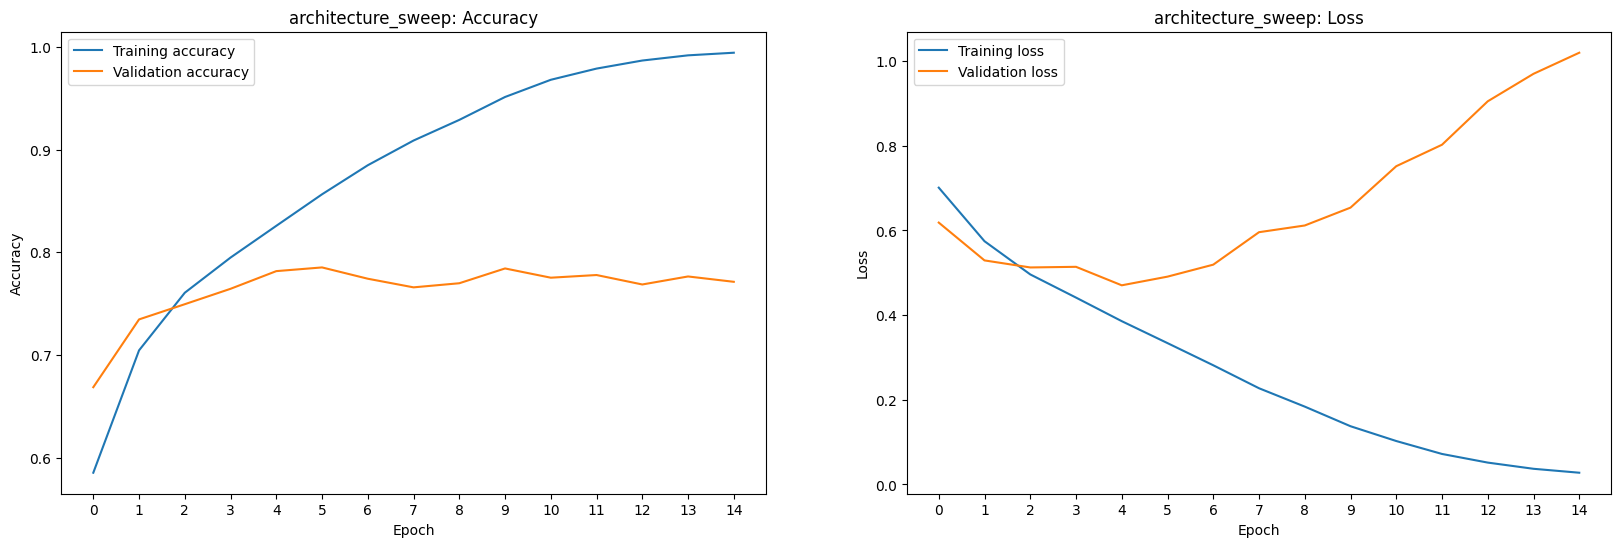

Current best validation accuracy:  0.9096916317939758
Testing architecture config (trial 20): [{'type': 'Conv2D', 'filters': 64, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Conv2D', 'filters': 64, 'kernel_size': (5, 5)}, {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, {'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, {'type': 'MaxPooling2D', 'pool_size': (3, 3)}, {'type': 'Flatten'}, {'type': 'Dense', 'units': 2, 'activation': 'softmax'}]
Building model: architecture_sweep...
Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_55 (Conv2D)          (None, 256, 256, 64)      1792      
                                                                 
 max_pooling2d_55 (MaxPoolin  (None, 128, 128, 64)     0         
 g2D)            

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 54s 83ms/step - loss: 0.6654 - acc: 0.5805 - val_loss: 0.6423 - val_acc: 0.6129
Epoch 2/15
625/625 [==============================] - 52s 83ms/step - loss: 0.5757 - acc: 0.6945 - val_loss: 0.5287 - val_acc: 0.7441
Epoch 3/15
625/625 [==============================] - 49s 78ms/step - loss: 0.5225 - acc: 0.7413 - val_loss: 0.5022 - val_acc: 0.7603
Epoch 4/15
625/625 [==============================] - 51s 82ms/step - loss: 0.4873 - acc: 0.7666 - val_loss: 0.4660 - val_acc: 0.7839
Epoch 5/15
625/625 [==============================] - 52s 82ms/step - loss: 0.4552 - acc: 0.7885 - val_loss: 0.4469 - val_acc: 0.7978
Epoch 6/15
625/625 [==============================] - 47s 75ms/step - loss: 0.4306 - acc: 0.8047 - val_loss: 0.4227 - val_acc: 0.8102
Epoch 7/15
625/625 [==============================] - 46s 73ms/step - loss: 0.4101 - acc: 0.8179 - val_loss: 0.4191 - val_acc: 0.8106
Epoch 8/15
625/625 [==============================] - 52s 83ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/architecture_sweep\assets


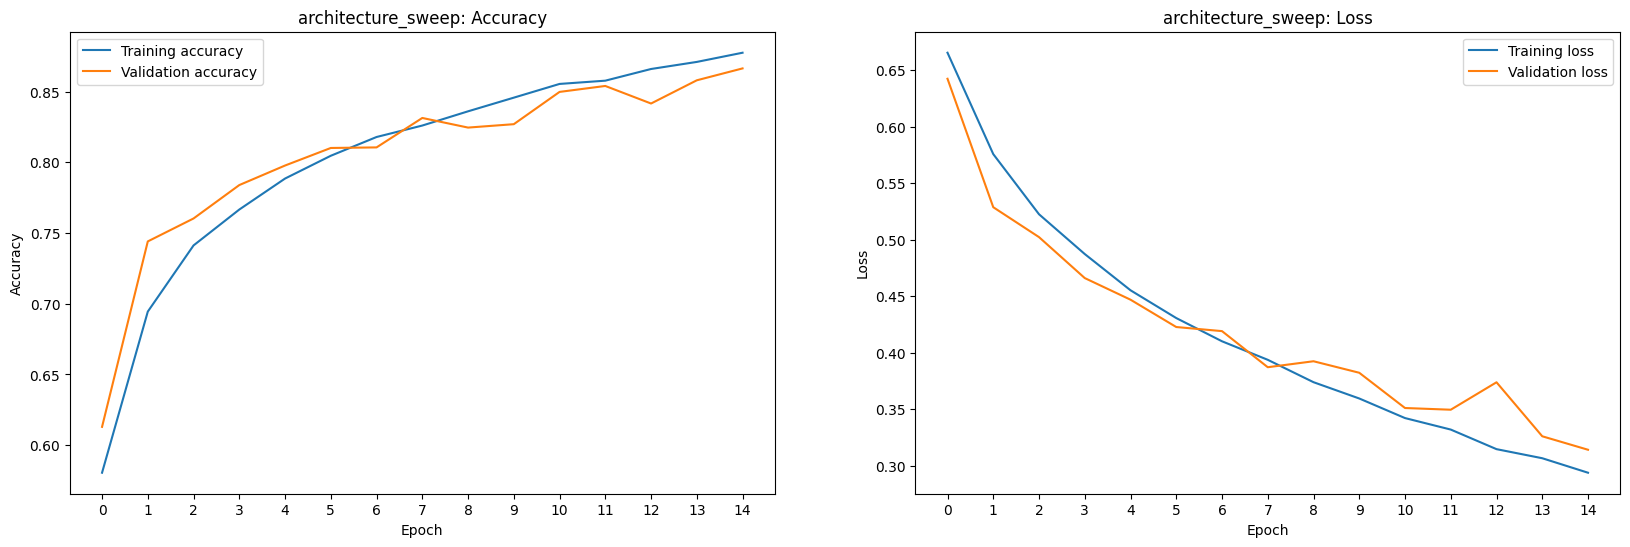

Current best validation accuracy:  0.9096916317939758


In [9]:
other_params = {
    "batch_size": 32,
    "activation_function": "relu",
    "epochs": 15,
    "loss_function": "binary_crossentropy"
}

# best config was found by running the sweep algorithm below
#best_config = sweep_architecture_params(BASE_IMAGE_DIR, 20, other_params=other_params)

best_config = [
    {'type': 'Conv2D', 'filters': 16, 'kernel_size': (3, 3)}, 
    {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, 
    {'type': 'Dropout', 'rate': 0.30703886128813807}, 
    {'type': 'Flatten'}, 
    {'type': 'Dense', 'units': 256, 'activation': 'tanh'},
    {'type': 'Dense', 'units': 2, 'activation': 'softmax'}
]



In [12]:
# LEGACY hardcodes candidate configs (pre random search)
candidate_architecture_configs = [
    # 2 convolutional layers, single dense layer
    [
        {"type": "Conv2D", "filters": 24, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 48, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Flatten"},
        {"type": "Dropout", "rate": 0.9},
        {"type": "Dense", "units": 2, "activation": "sigmoid"}
    ],
    # 3 convolutional layers, 2 dense layers (prev best)
    [
        {"type": "Conv2D", "filters": 24, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 48, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 128, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Flatten"},
        {"type": "Dropout", "rate": 0.9},
        {"type": "Dense", "units": 64, "activation": "relu"},
        {"type": "Dense", "units": 2, "activation": "sigmoid"}
    ],
    # single conolutional layer, single dense layer
    [
        {"type": "Conv2D", "filters": 24, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Flatten"},
        {"type": "Dropout", "rate": 0.9},
        {"type": "Dense", "units": 64, "activation": "relu"},
        {"type": "Dense", "units": 2, "activation": "sigmoid"}
    ],
    [
        # 3 convolutional layers, single dense layer
        {"type": "Conv2D", "filters": 24, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 48, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Conv2D", "filters": 96, "kernel_size": (5, 5)},
        {"type": "MaxPooling2D", "pool_size": (2, 2)},
        {"type": "Flatten"},
        {"type": "Dropout", "rate": 0.9},
        {"type": "Dense", "units": 2, "activation": "sigmoid"}
    ],
]



### Grid search for params based on fixed architecture

In [13]:
# of the candidate architectures, the second one in the list is best
# now, run a grid search to find other params

# UNCOMMENT AFTER RUNNING
#best_config = candidate_architecture_configs[1]

## REMOVE AFTER RUNNING 
best_config = [
    {'type': 'Conv2D', 'filters': 24, 'kernel_size': (5, 5)}, 
    {'type': 'MaxPooling2D', 'pool_size': (2, 2)},
    {'type': 'Conv2D', 'filters': 48, 'kernel_size': (5, 5)}, 
    {'type': 'MaxPooling2D', 'pool_size': (2, 2)},
    {'type': 'Conv2D', 'filters': 96, 'kernel_size': (5, 5)},
    {'type': 'MaxPooling2D', 'pool_size': (2, 2)}, 
    {'type': 'Flatten'},
    {'type': 'Dropout', 'rate': 0.9}, 
    {'type': 'Dense', 'units': 64, 'activation': 'relu'}, 
    {'type': 'Dense', 'units': 2, 'activation': 'sigmoid'}
]



activation_functions = ['relu', 'sigmoid']
batch_sizes = [16, 32, 64]
loss_functions = ['binary_crossentropy']
epochs_list = [15]
dropout_rates = [0.5, 0.9]

# call the grid search function to evaluate the best model combination
results = grid_search(
    BASE_IMAGE_DIR,
    best_config,
    activation_functions,
    batch_sizes,
    loss_functions, 
    epochs_list,
    dropout_rates)



Training model: model_relu_16_binary_crossentropy_15_0.5
Building model: model_relu_16_binary_crossentropy_15_0.5...
Using dropout rate: 0.5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 256, 256, 24)      1824      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 128, 128, 24)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 128, 128, 48)      28848     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 64, 64, 48)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 64, 64, 9

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 42s 33ms/step - loss: 0.5782 - acc: 0.6865 - val_loss: 0.4972 - val_acc: 0.7555
Epoch 2/15
1249/1249 [==============================] - 42s 34ms/step - loss: 0.4567 - acc: 0.7834 - val_loss: 0.4251 - val_acc: 0.8036
Epoch 3/15
1249/1249 [==============================] - 42s 34ms/step - loss: 0.3891 - acc: 0.8240 - val_loss: 0.4313 - val_acc: 0.7978
Epoch 4/15
1249/1249 [==============================] - 41s 32ms/step - loss: 0.3382 - acc: 0.8512 - val_loss: 0.3976 - val_acc: 0.8230
Epoch 5/15
1249/1249 [==============================] - 45s 36ms/step - loss: 0.2862 - acc: 0.8778 - val_loss: 0.3856 - val_acc: 0.8296
Epoch 6/15
1249/1249 [==============================] - 39s 31ms/step - loss: 0.2322 - acc: 0.9018 - val_loss: 0.3834 - val_acc: 0.8416
Epoch 7/15
1249/1249 [==============================] - 43s 34ms/step - loss: 0.1754 - acc: 0.9282 - val_loss: 0.4077 - val_acc: 0.8436
Epoch 8/15
1249/1249 [==============================] - 40s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_16_binary_crossentropy_15_0.5\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_16_binary_crossentropy_15_0.5\assets


Training model: model_relu_16_binary_crossentropy_15_0.9
Building model: model_relu_16_binary_crossentropy_15_0.9...
Using dropout rate: 0.9
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 256, 256, 24)      1824      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 128, 128, 24)     0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 128, 128, 48)      28848     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 64, 64, 48)       0         
 2D)                                                             
                                                                 
 conv2d_8 (Conv2D)           (None, 64, 64, 9

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 41s 32ms/step - loss: 0.6160 - acc: 0.6443 - val_loss: 0.5186 - val_acc: 0.7453
Epoch 2/15
1249/1249 [==============================] - 39s 31ms/step - loss: 0.5310 - acc: 0.7334 - val_loss: 0.4893 - val_acc: 0.7585
Epoch 3/15
1249/1249 [==============================] - 44s 35ms/step - loss: 0.4877 - acc: 0.7656 - val_loss: 0.4750 - val_acc: 0.7685
Epoch 4/15
1249/1249 [==============================] - 44s 35ms/step - loss: 0.4484 - acc: 0.7926 - val_loss: 0.4208 - val_acc: 0.8024
Epoch 5/15
1249/1249 [==============================] - 44s 35ms/step - loss: 0.4181 - acc: 0.8086 - val_loss: 0.4369 - val_acc: 0.7988
Epoch 6/15
1249/1249 [==============================] - 38s 31ms/step - loss: 0.3936 - acc: 0.8235 - val_loss: 0.3959 - val_acc: 0.8166
Epoch 7/15
1249/1249 [==============================] - 42s 34ms/step - loss: 0.3714 - acc: 0.8357 - val_loss: 0.3568 - val_acc: 0.8392
Epoch 8/15
1249/1249 [==============================] - 38s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_16_binary_crossentropy_15_0.9\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_16_binary_crossentropy_15_0.9\assets


Training model: model_relu_32_binary_crossentropy_15_0.5
Building model: model_relu_32_binary_crossentropy_15_0.5...
Using dropout rate: 0.5
Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 256, 256, 24)      1824      
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 128, 128, 24)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 128, 128, 48)      28848     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 64, 64, 48)       0         
 g2D)                                                            
                                                                 
 conv2d_11 (Conv2D)          (None, 64, 64, 9

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 38s 57ms/step - loss: 0.6099 - acc: 0.6471 - val_loss: 0.5517 - val_acc: 0.7095
Epoch 2/15
625/625 [==============================] - 37s 59ms/step - loss: 0.5027 - acc: 0.7544 - val_loss: 0.4846 - val_acc: 0.7599
Epoch 3/15
625/625 [==============================] - 39s 61ms/step - loss: 0.4344 - acc: 0.7980 - val_loss: 0.4249 - val_acc: 0.8036
Epoch 4/15
625/625 [==============================] - 40s 64ms/step - loss: 0.3853 - acc: 0.8251 - val_loss: 0.4118 - val_acc: 0.8166
Epoch 5/15
625/625 [==============================] - 37s 59ms/step - loss: 0.3427 - acc: 0.8483 - val_loss: 0.3778 - val_acc: 0.8308
Epoch 6/15
625/625 [==============================] - 39s 62ms/step - loss: 0.2927 - acc: 0.8752 - val_loss: 0.3969 - val_acc: 0.8358
Epoch 7/15
625/625 [==============================] - 41s 65ms/step - loss: 0.2505 - acc: 0.8939 - val_loss: 0.3770 - val_acc: 0.8336
Epoch 8/15
625/625 [==============================] - 39s 62ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_32_binary_crossentropy_15_0.5\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_32_binary_crossentropy_15_0.5\assets


Training model: model_relu_32_binary_crossentropy_15_0.9
Building model: model_relu_32_binary_crossentropy_15_0.9...
Using dropout rate: 0.9
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 256, 256, 24)      1824      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 128, 128, 24)     0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 128, 128, 48)      28848     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 64, 64, 48)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 9

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 40s 62ms/step - loss: 0.6126 - acc: 0.6454 - val_loss: 0.5464 - val_acc: 0.7135
Epoch 2/15
625/625 [==============================] - 39s 62ms/step - loss: 0.5309 - acc: 0.7308 - val_loss: 0.4858 - val_acc: 0.7721
Epoch 3/15
625/625 [==============================] - 40s 63ms/step - loss: 0.4717 - acc: 0.7698 - val_loss: 0.4450 - val_acc: 0.7924
Epoch 4/15
625/625 [==============================] - 38s 61ms/step - loss: 0.4336 - acc: 0.7983 - val_loss: 0.3967 - val_acc: 0.8266
Epoch 5/15
625/625 [==============================] - 37s 59ms/step - loss: 0.4039 - acc: 0.8167 - val_loss: 0.4021 - val_acc: 0.8182
Epoch 6/15
625/625 [==============================] - 36s 57ms/step - loss: 0.3808 - acc: 0.8294 - val_loss: 0.3859 - val_acc: 0.8266
Epoch 7/15
625/625 [==============================] - 39s 62ms/step - loss: 0.3611 - acc: 0.8384 - val_loss: 0.4009 - val_acc: 0.8258
Epoch 8/15
625/625 [==============================] - 38s 60ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_32_binary_crossentropy_15_0.9\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_32_binary_crossentropy_15_0.9\assets


Training model: model_relu_64_binary_crossentropy_15_0.5
Building model: model_relu_64_binary_crossentropy_15_0.5...
Using dropout rate: 0.5
Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_15 (Conv2D)          (None, 256, 256, 24)      1824      
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 128, 128, 24)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 128, 128, 48)      28848     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 64, 64, 48)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 64, 64, 9

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


313/313 [==============================] - 40s 117ms/step - loss: 0.6518 - acc: 0.6149 - val_loss: 0.5573 - val_acc: 0.7133
Epoch 2/15
313/313 [==============================] - 36s 113ms/step - loss: 0.5424 - acc: 0.7238 - val_loss: 0.5143 - val_acc: 0.7547
Epoch 3/15
313/313 [==============================] - 37s 118ms/step - loss: 0.4934 - acc: 0.7590 - val_loss: 0.4829 - val_acc: 0.7727
Epoch 4/15
313/313 [==============================] - 39s 122ms/step - loss: 0.4504 - acc: 0.7892 - val_loss: 0.4358 - val_acc: 0.7996
Epoch 5/15
313/313 [==============================] - 1169s 4s/step - loss: 0.4076 - acc: 0.8123 - val_loss: 0.4410 - val_acc: 0.7976
Epoch 6/15
313/313 [==============================] - 37s 117ms/step - loss: 0.3673 - acc: 0.8373 - val_loss: 0.4173 - val_acc: 0.8086
Epoch 7/15
313/313 [==============================] - 37s 117ms/step - loss: 0.3315 - acc: 0.8542 - val_loss: 0.3956 - val_acc: 0.8164
Epoch 8/15
313/313 [==============================] - 36s 113ms/ste

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_64_binary_crossentropy_15_0.5\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_64_binary_crossentropy_15_0.5\assets


Training model: model_relu_64_binary_crossentropy_15_0.9
Building model: model_relu_64_binary_crossentropy_15_0.9...
Using dropout rate: 0.9
Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 256, 256, 24)      1824      
                                                                 
 max_pooling2d_18 (MaxPoolin  (None, 128, 128, 24)     0         
 g2D)                                                            
                                                                 
 conv2d_19 (Conv2D)          (None, 128, 128, 48)      28848     
                                                                 
 max_pooling2d_19 (MaxPoolin  (None, 64, 64, 48)       0         
 g2D)                                                            
                                                                 
 conv2d_20 (Conv2D)          (None, 64, 64, 9

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


313/313 [==============================] - 42s 130ms/step - loss: 0.6312 - acc: 0.6210 - val_loss: 0.5464 - val_acc: 0.7229
Epoch 2/15
313/313 [==============================] - 38s 119ms/step - loss: 0.5407 - acc: 0.7262 - val_loss: 0.5125 - val_acc: 0.7539
Epoch 3/15
313/313 [==============================] - 37s 118ms/step - loss: 0.4977 - acc: 0.7531 - val_loss: 0.4861 - val_acc: 0.7677
Epoch 4/15
313/313 [==============================] - 37s 117ms/step - loss: 0.4621 - acc: 0.7794 - val_loss: 0.4536 - val_acc: 0.7928
Epoch 5/15
313/313 [==============================] - 37s 117ms/step - loss: 0.4348 - acc: 0.7965 - val_loss: 0.4140 - val_acc: 0.8054
Epoch 6/15
313/313 [==============================] - 39s 123ms/step - loss: 0.4045 - acc: 0.8141 - val_loss: 0.3866 - val_acc: 0.8234
Epoch 7/15
313/313 [==============================] - 35s 109ms/step - loss: 0.3802 - acc: 0.8324 - val_loss: 0.3923 - val_acc: 0.8256
Epoch 8/15
313/313 [==============================] - 35s 110ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_64_binary_crossentropy_15_0.9\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_relu_64_binary_crossentropy_15_0.9\assets


Training model: model_sigmoid_16_binary_crossentropy_15_0.5
Building model: model_sigmoid_16_binary_crossentropy_15_0.5...
Using dropout rate: 0.5
Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 256, 256, 24)      1824      
                                                                 
 max_pooling2d_21 (MaxPoolin  (None, 128, 128, 24)     0         
 g2D)                                                            
                                                                 
 conv2d_22 (Conv2D)          (None, 128, 128, 48)      28848     
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 64, 64, 48)       0         
 g2D)                                                            
                                                                 
 conv2d_23 (Conv2D)          (None, 64,

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 49s 38ms/step - loss: 0.7820 - acc: 0.5042 - val_loss: 0.6938 - val_acc: 0.5000
Epoch 2/15
1249/1249 [==============================] - 44s 35ms/step - loss: 0.6937 - acc: 0.5033 - val_loss: 0.6931 - val_acc: 0.4960
Epoch 3/15
1249/1249 [==============================] - 44s 35ms/step - loss: 0.6937 - acc: 0.4957 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/15
1249/1249 [==============================] - 44s 35ms/step - loss: 0.6932 - acc: 0.4984 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/15
1249/1249 [==============================] - 46s 36ms/step - loss: 0.6932 - acc: 0.4970 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/15
1249/1249 [==============================] - 42s 33ms/step - loss: 0.6932 - acc: 0.4948 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 7/15
1249/1249 [==============================] - 44s 35ms/step - loss: 0.6932 - acc: 0.4958 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 8/15
1249/1249 [==============================] - 45s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_16_binary_crossentropy_15_0.5\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_16_binary_crossentropy_15_0.5\assets


Training model: model_sigmoid_16_binary_crossentropy_15_0.9
Building model: model_sigmoid_16_binary_crossentropy_15_0.9...
Using dropout rate: 0.9
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 256, 256, 24)      1824      
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 128, 128, 24)     0         
 g2D)                                                            
                                                                 
 conv2d_25 (Conv2D)          (None, 128, 128, 48)      28848     
                                                                 
 max_pooling2d_25 (MaxPoolin  (None, 64, 64, 48)       0         
 g2D)                                                            
                                                                 
 conv2d_26 (Conv2D)          (None, 64,

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


1249/1249 [==============================] - 47s 37ms/step - loss: 0.7142 - acc: 0.4992 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/15
1249/1249 [==============================] - 44s 35ms/step - loss: 0.6932 - acc: 0.4994 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/15
1249/1249 [==============================] - 46s 37ms/step - loss: 0.6933 - acc: 0.5006 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/15
1249/1249 [==============================] - 43s 35ms/step - loss: 0.6938 - acc: 0.4957 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 5/15
1249/1249 [==============================] - 47s 38ms/step - loss: 0.6933 - acc: 0.5002 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/15
1249/1249 [==============================] - 46s 37ms/step - loss: 0.6933 - acc: 0.5036 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 7/15
1249/1249 [==============================] - 42s 34ms/step - loss: 0.6933 - acc: 0.4985 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 8/15
1249/1249 [==============================] - 42s

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_16_binary_crossentropy_15_0.9\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_16_binary_crossentropy_15_0.9\assets


Training model: model_sigmoid_32_binary_crossentropy_15_0.5
Building model: model_sigmoid_32_binary_crossentropy_15_0.5...
Using dropout rate: 0.5
Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_27 (Conv2D)          (None, 256, 256, 24)      1824      
                                                                 
 max_pooling2d_27 (MaxPoolin  (None, 128, 128, 24)     0         
 g2D)                                                            
                                                                 
 conv2d_28 (Conv2D)          (None, 128, 128, 48)      28848     
                                                                 
 max_pooling2d_28 (MaxPoolin  (None, 64, 64, 48)       0         
 g2D)                                                            
                                                                 
 conv2d_29 (Conv2D)          (None, 64,

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 42s 66ms/step - loss: 0.8966 - acc: 0.5012 - val_loss: 0.6934 - val_acc: 0.5000
Epoch 2/15
625/625 [==============================] - 39s 63ms/step - loss: 0.6935 - acc: 0.4948 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/15
625/625 [==============================] - 43s 68ms/step - loss: 0.6933 - acc: 0.5015 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/15
625/625 [==============================] - 41s 65ms/step - loss: 0.6935 - acc: 0.5012 - val_loss: 0.6932 - val_acc: 0.4940
Epoch 5/15
625/625 [==============================] - 41s 65ms/step - loss: 0.6932 - acc: 0.4990 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 6/15
625/625 [==============================] - 41s 66ms/step - loss: 0.6932 - acc: 0.4965 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 7/15
625/625 [==============================] - 39s 62ms/step - loss: 0.6932 - acc: 0.4970 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 8/15
625/625 [==============================] - 41s 66ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_32_binary_crossentropy_15_0.5\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_32_binary_crossentropy_15_0.5\assets


Training model: model_sigmoid_32_binary_crossentropy_15_0.9
Building model: model_sigmoid_32_binary_crossentropy_15_0.9...
Using dropout rate: 0.9
Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_30 (Conv2D)          (None, 256, 256, 24)      1824      
                                                                 
 max_pooling2d_30 (MaxPoolin  (None, 128, 128, 24)     0         
 g2D)                                                            
                                                                 
 conv2d_31 (Conv2D)          (None, 128, 128, 48)      28848     
                                                                 
 max_pooling2d_31 (MaxPoolin  (None, 64, 64, 48)       0         
 g2D)                                                            
                                                                 
 conv2d_32 (Conv2D)          (None, 64

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


625/625 [==============================] - 43s 68ms/step - loss: 0.7383 - acc: 0.4975 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 2/15
625/625 [==============================] - 42s 67ms/step - loss: 0.6933 - acc: 0.5008 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/15
625/625 [==============================] - 40s 64ms/step - loss: 0.6933 - acc: 0.5013 - val_loss: 0.6932 - val_acc: 0.5000
Epoch 4/15
625/625 [==============================] - 41s 65ms/step - loss: 0.6934 - acc: 0.5030 - val_loss: 0.6931 - val_acc: 0.5284
Epoch 5/15
625/625 [==============================] - 44s 70ms/step - loss: 0.6932 - acc: 0.5045 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/15
625/625 [==============================] - 41s 65ms/step - loss: 0.6933 - acc: 0.5017 - val_loss: 0.6931 - val_acc: 0.4988
Epoch 7/15
625/625 [==============================] - 42s 67ms/step - loss: 0.6932 - acc: 0.5010 - val_loss: 0.6931 - val_acc: 0.5078
Epoch 8/15
625/625 [==============================] - 42s 67ms/step - los

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_32_binary_crossentropy_15_0.9\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_32_binary_crossentropy_15_0.9\assets


Training model: model_sigmoid_64_binary_crossentropy_15_0.5
Building model: model_sigmoid_64_binary_crossentropy_15_0.5...
Using dropout rate: 0.5
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 256, 256, 24)      1824      
                                                                 
 max_pooling2d_33 (MaxPoolin  (None, 128, 128, 24)     0         
 g2D)                                                            
                                                                 
 conv2d_34 (Conv2D)          (None, 128, 128, 48)      28848     
                                                                 
 max_pooling2d_34 (MaxPoolin  (None, 64, 64, 48)       0         
 g2D)                                                            
                                                                 
 conv2d_35 (Conv2D)          (None, 64

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


313/313 [==============================] - 42s 130ms/step - loss: 0.9823 - acc: 0.5026 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/15
313/313 [==============================] - 40s 125ms/step - loss: 0.6932 - acc: 0.5014 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/15
313/313 [==============================] - 39s 123ms/step - loss: 0.6932 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/15
313/313 [==============================] - 38s 122ms/step - loss: 0.6931 - acc: 0.4982 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/15
313/313 [==============================] - 40s 126ms/step - loss: 0.6932 - acc: 0.4980 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/15
313/313 [==============================] - 40s 127ms/step - loss: 0.6932 - acc: 0.4996 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 7/15
313/313 [==============================] - 39s 122ms/step - loss: 0.6932 - acc: 0.5003 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 8/15
313/313 [==============================] - 42s 133ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_64_binary_crossentropy_15_0.5\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_64_binary_crossentropy_15_0.5\assets


Training model: model_sigmoid_64_binary_crossentropy_15_0.9
Building model: model_sigmoid_64_binary_crossentropy_15_0.9...
Using dropout rate: 0.9
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 256, 256, 24)      1824      
                                                                 
 max_pooling2d_36 (MaxPoolin  (None, 128, 128, 24)     0         
 g2D)                                                            
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 48)      28848     
                                                                 
 max_pooling2d_37 (MaxPoolin  (None, 64, 64, 48)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 64

C:\Users\nates\anaconda3\envs\tflow\lib\site-packages\PIL\TiffImagePlugin.py:864: UserWarning: Truncated File Read
  warnings.warn(str(msg))


313/313 [==============================] - 39s 123ms/step - loss: 0.8901 - acc: 0.4982 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 2/15
313/313 [==============================] - 42s 133ms/step - loss: 0.6932 - acc: 0.5016 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/15
313/313 [==============================] - 39s 122ms/step - loss: 0.6932 - acc: 0.4988 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 4/15
313/313 [==============================] - 40s 125ms/step - loss: 0.6932 - acc: 0.4969 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 5/15
313/313 [==============================] - 39s 123ms/step - loss: 0.6932 - acc: 0.4921 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 6/15
313/313 [==============================] - 39s 122ms/step - loss: 0.6932 - acc: 0.4938 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 7/15
313/313 [==============================] - 37s 118ms/step - loss: 0.6932 - acc: 0.4971 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 8/15
313/313 [==============================] - 39s 124ms/st

INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_64_binary_crossentropy_15_0.9\assets


INFO:tensorflow:Assets written to: C:\dev\programming_2023\cnn_project\kagglecatsanddogs_5340\PetImages/models/model_sigmoid_64_binary_crossentropy_15_0.9\assets


{'model_name': 'model_relu_16_binary_crossentropy_15_0.5', 'activation_function': 'relu', 'batch_size': 16, 'loss_function': 'binary_crossentropy', 'epochs': 15, 'accuracy': [0.6864521503448486, 0.7833942174911499, 0.8239827752113342, 0.8512086272239685, 0.8778339624404907, 0.9018067121505737, 0.9281817674636841, 0.9494019150733948, 0.9616135358810425, 0.9711225628852844, 0.9772784113883972, 0.9827336072921753, 0.9867374300956726, 0.9883889555931091, 0.9901406168937683], 'validation_accuracy': [0.7555066347122192, 0.8035642504692078, 0.7977573275566101, 0.8229875564575195, 0.8295955061912537, 0.8416099548339844, 0.8436123132705688, 0.846015214920044, 0.8466159105300903, 0.848418116569519, 0.8436123132705688, 0.8454145193099976, 0.8354024887084961, 0.8498197793960571, 0.854425311088562], 'loss': [0.5782287120819092, 0.4567152261734009, 0.3891046345233917, 0.3382469415664673, 0.28615468740463257, 0.23219141364097595, 0.1754317283630371, 0.13332240283489227, 0.09885363280773163, 0.0795550

Model: model_relu_16_binary_crossentropy_15_0.5, best validation accuracy: 0.854425311088562


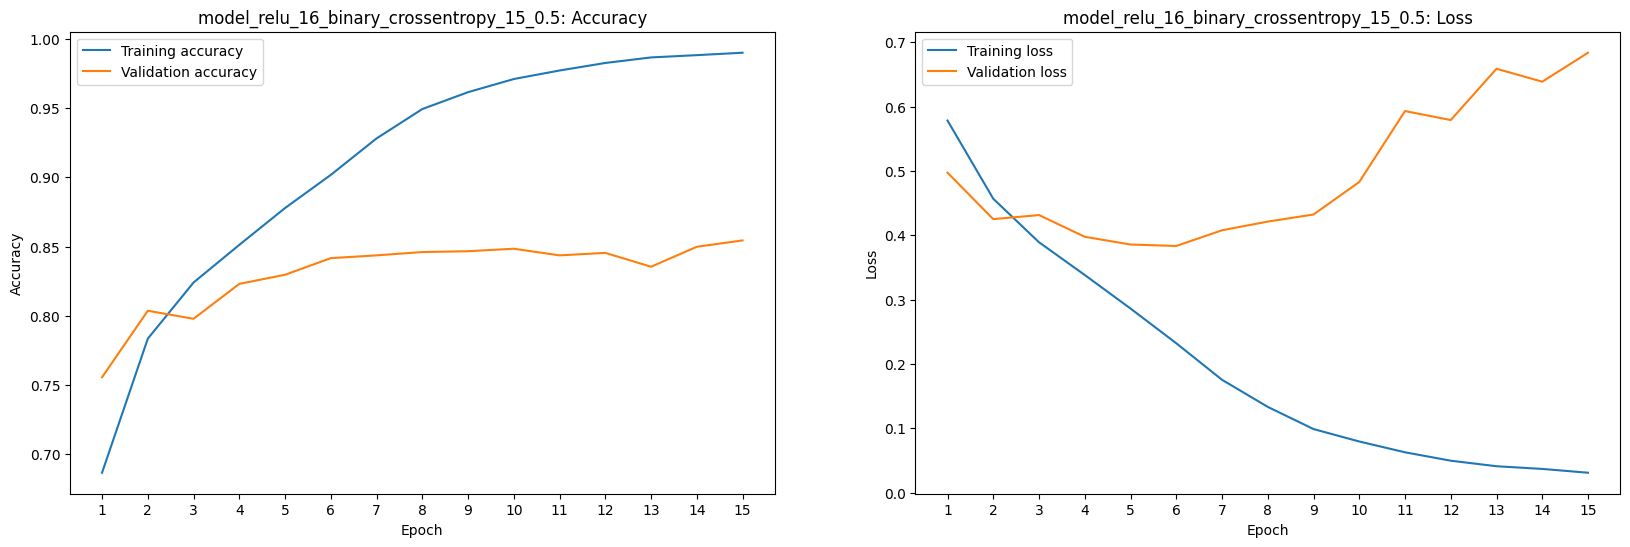

Model: model_relu_16_binary_crossentropy_15_0.9, best validation accuracy: 0.8712455034255981


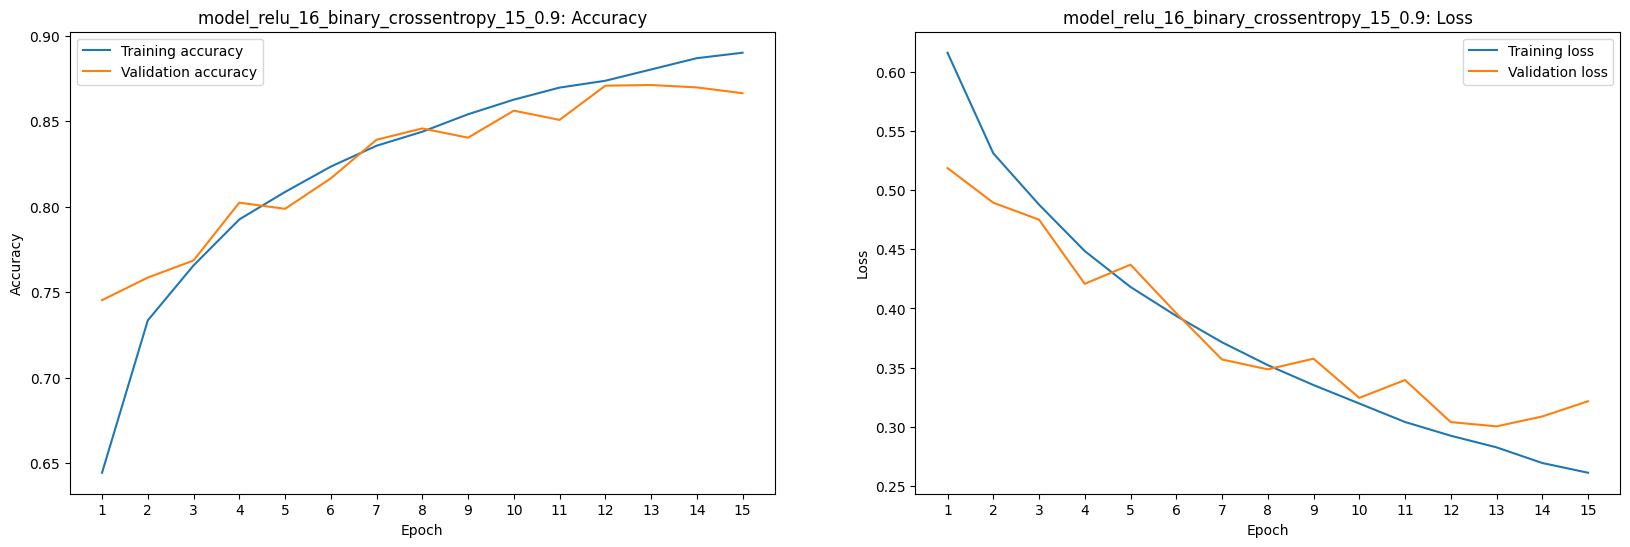

Model: model_relu_32_binary_crossentropy_15_0.5, best validation accuracy: 0.8492190837860107


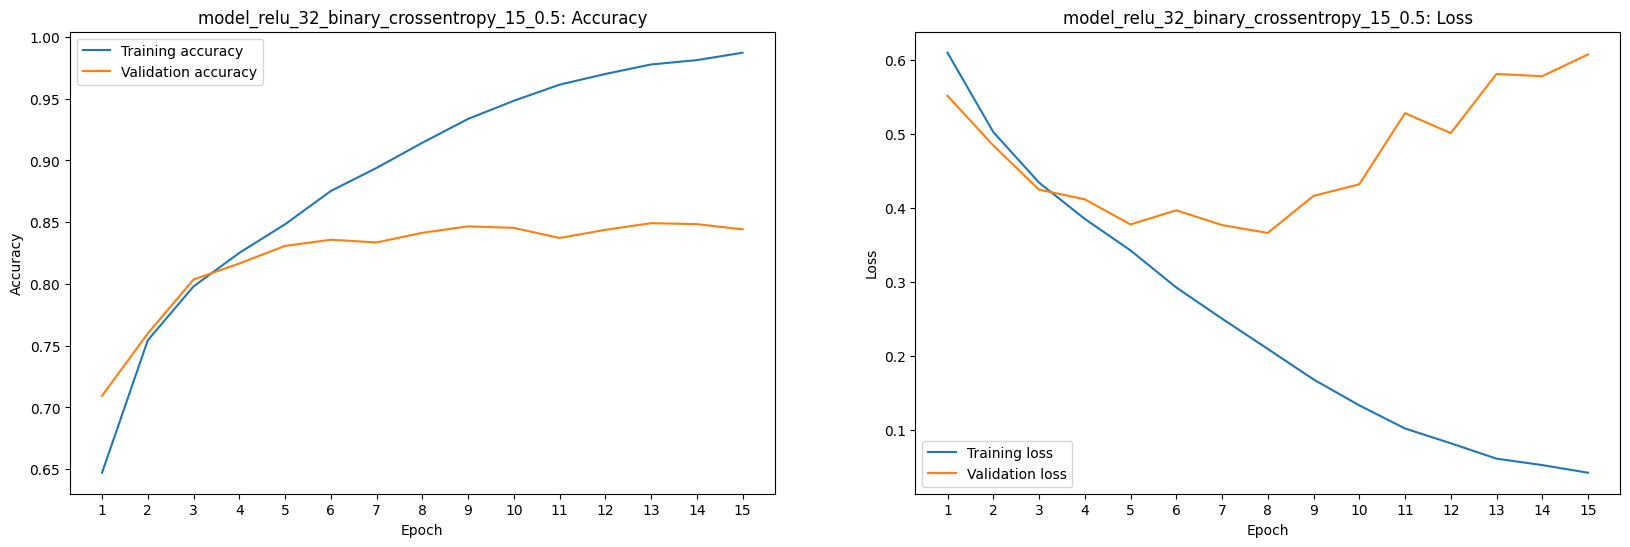

Model: model_relu_32_binary_crossentropy_15_0.9, best validation accuracy: 0.8690428733825684


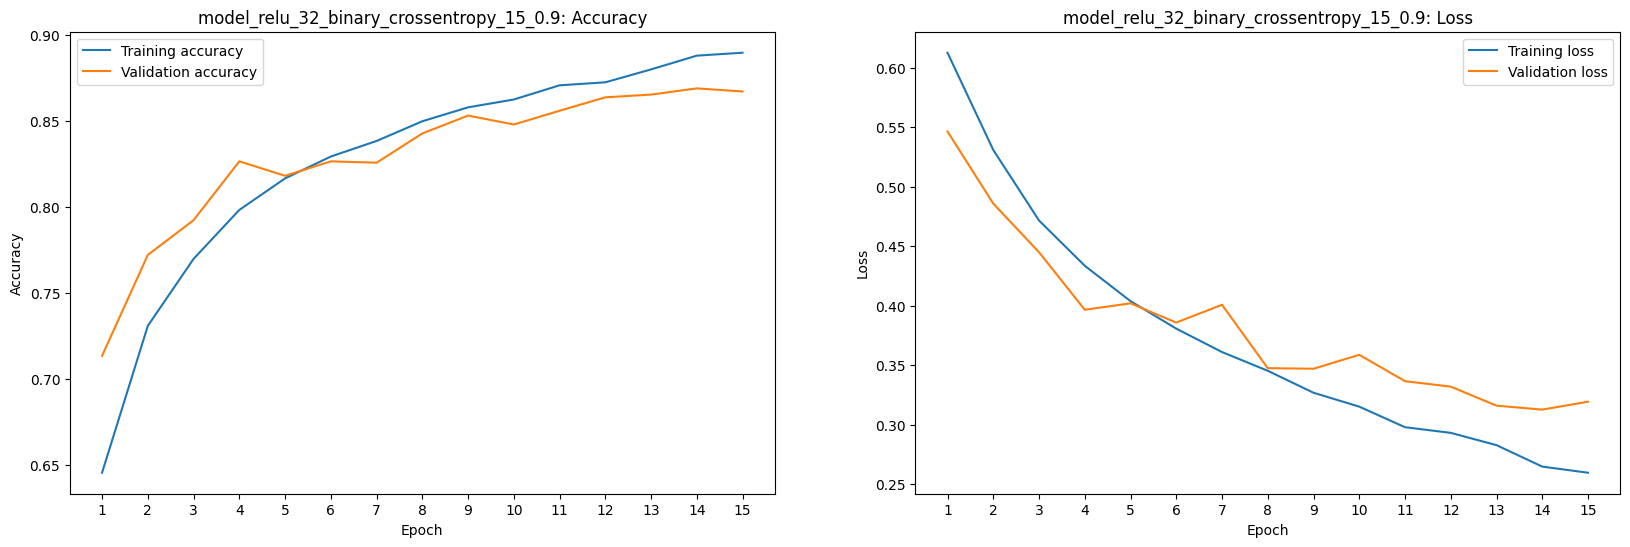

Model: model_relu_64_binary_crossentropy_15_0.5, best validation accuracy: 0.8512214422225952


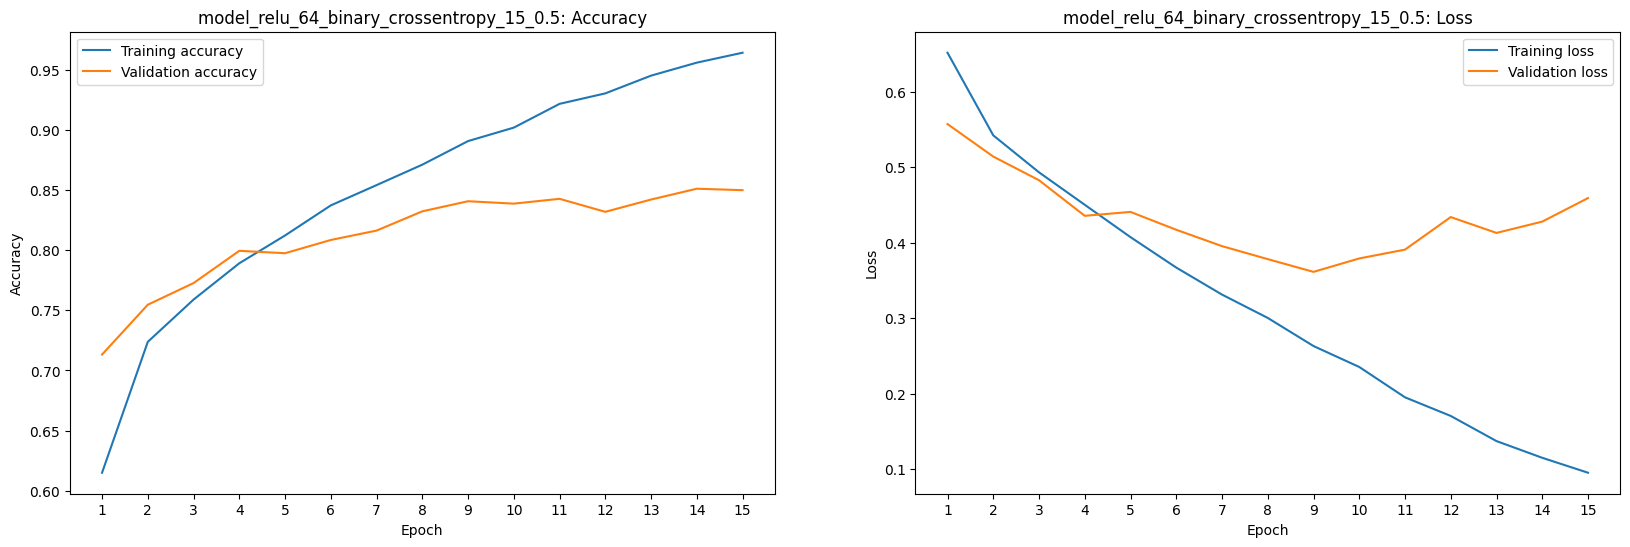

Model: model_relu_64_binary_crossentropy_15_0.9, best validation accuracy: 0.8736484050750732


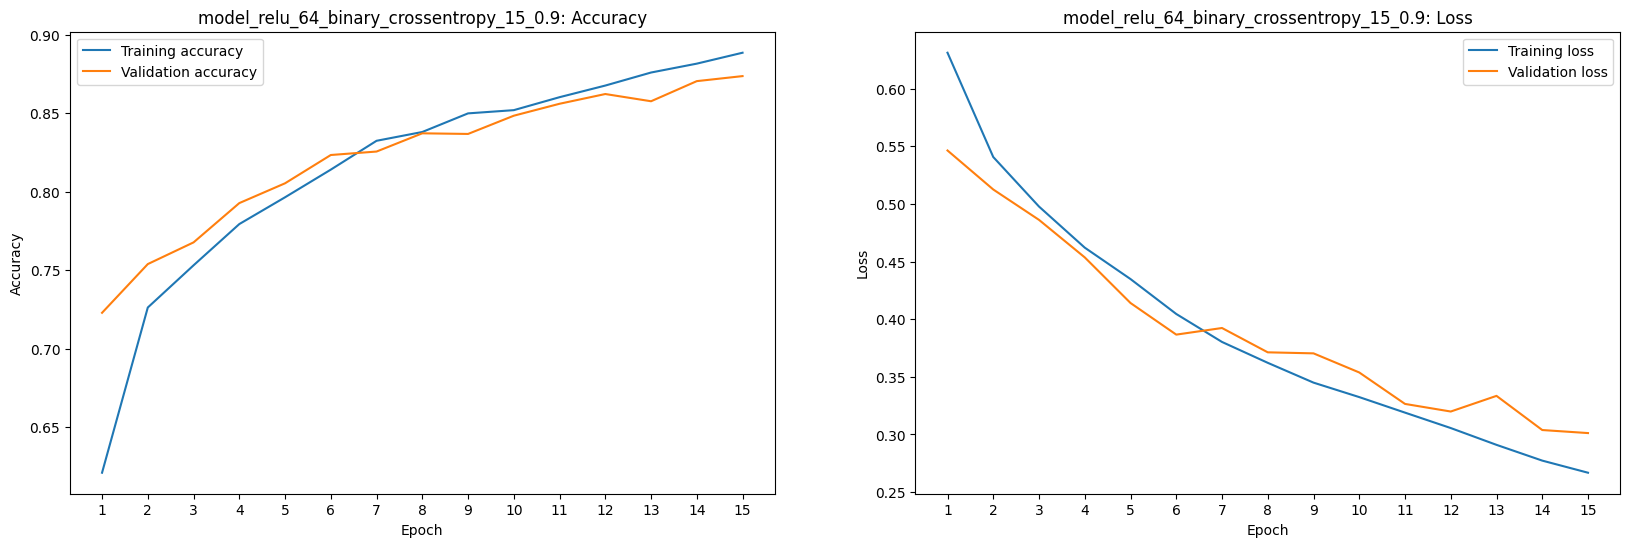

Model: model_sigmoid_16_binary_crossentropy_15_0.5, best validation accuracy: 0.5


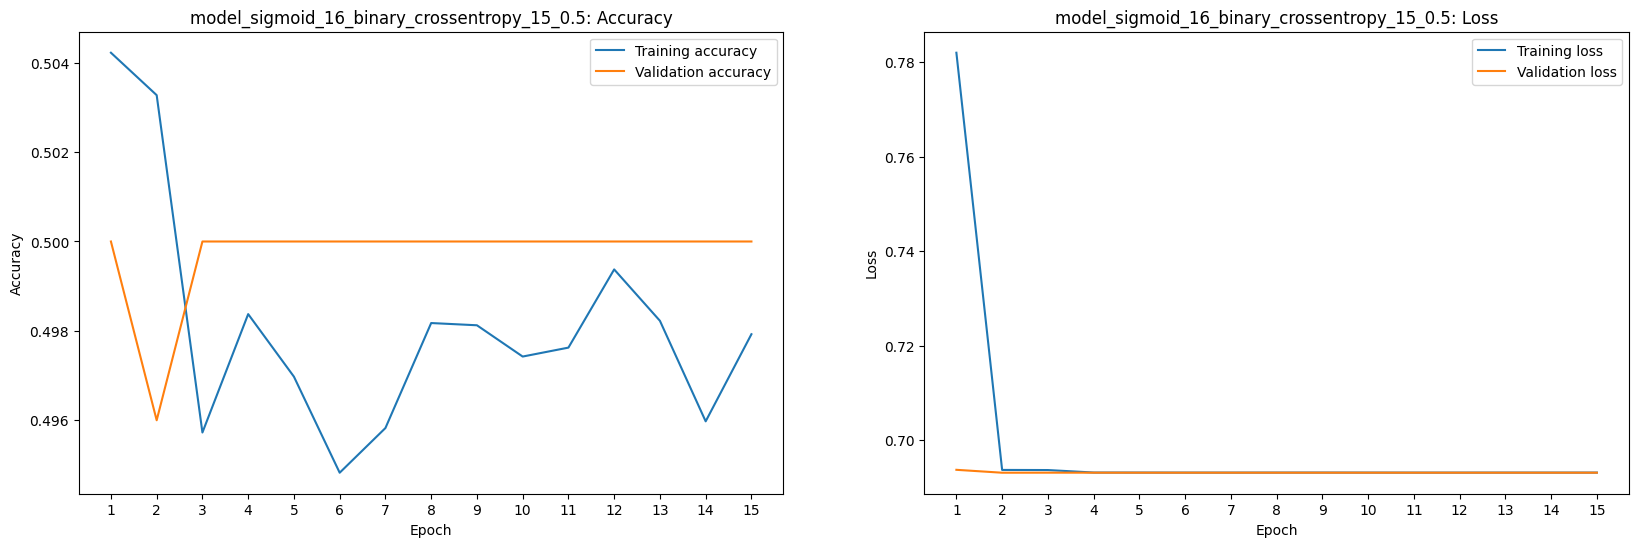

Model: model_sigmoid_16_binary_crossentropy_15_0.9, best validation accuracy: 0.5


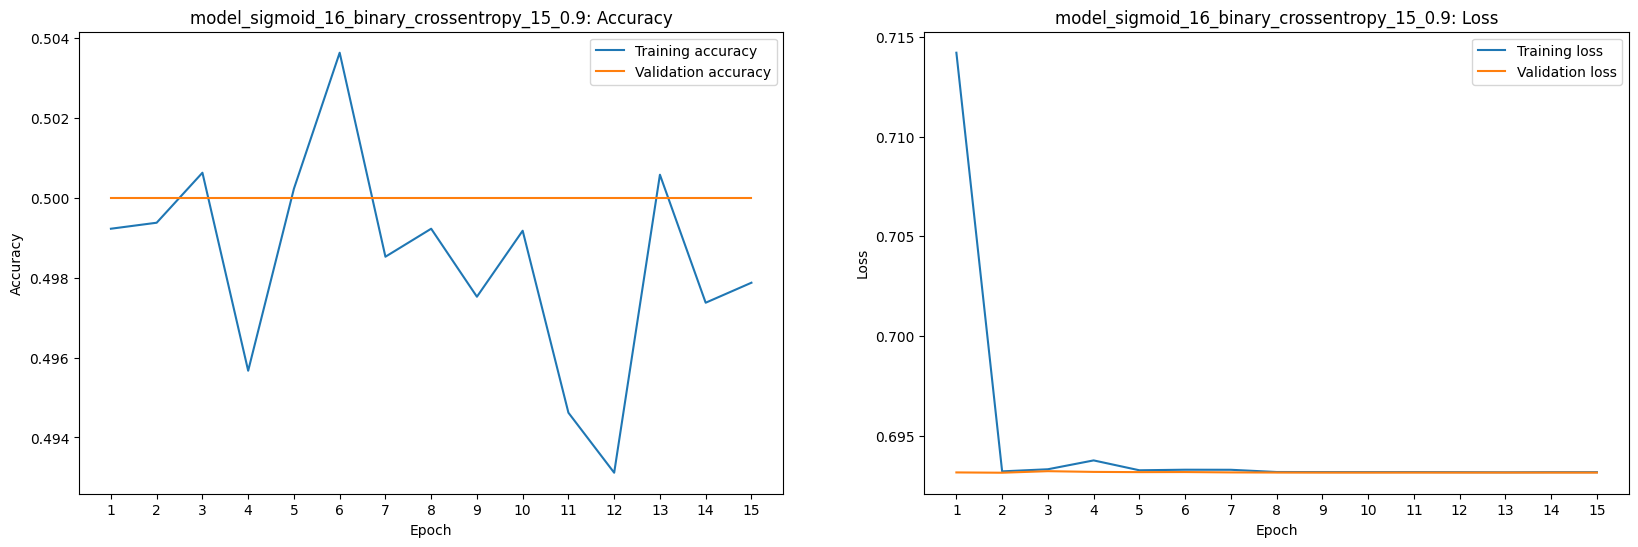

Model: model_sigmoid_32_binary_crossentropy_15_0.5, best validation accuracy: 0.5


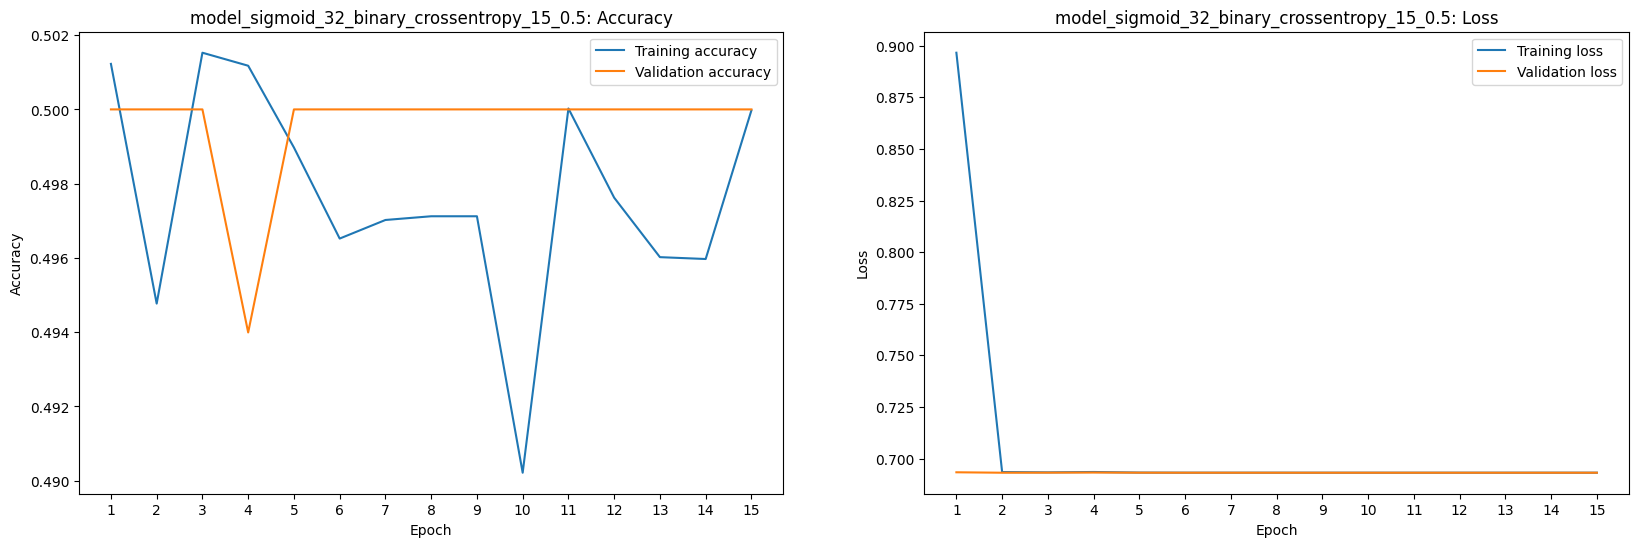

Model: model_sigmoid_32_binary_crossentropy_15_0.9, best validation accuracy: 0.6021225452423096


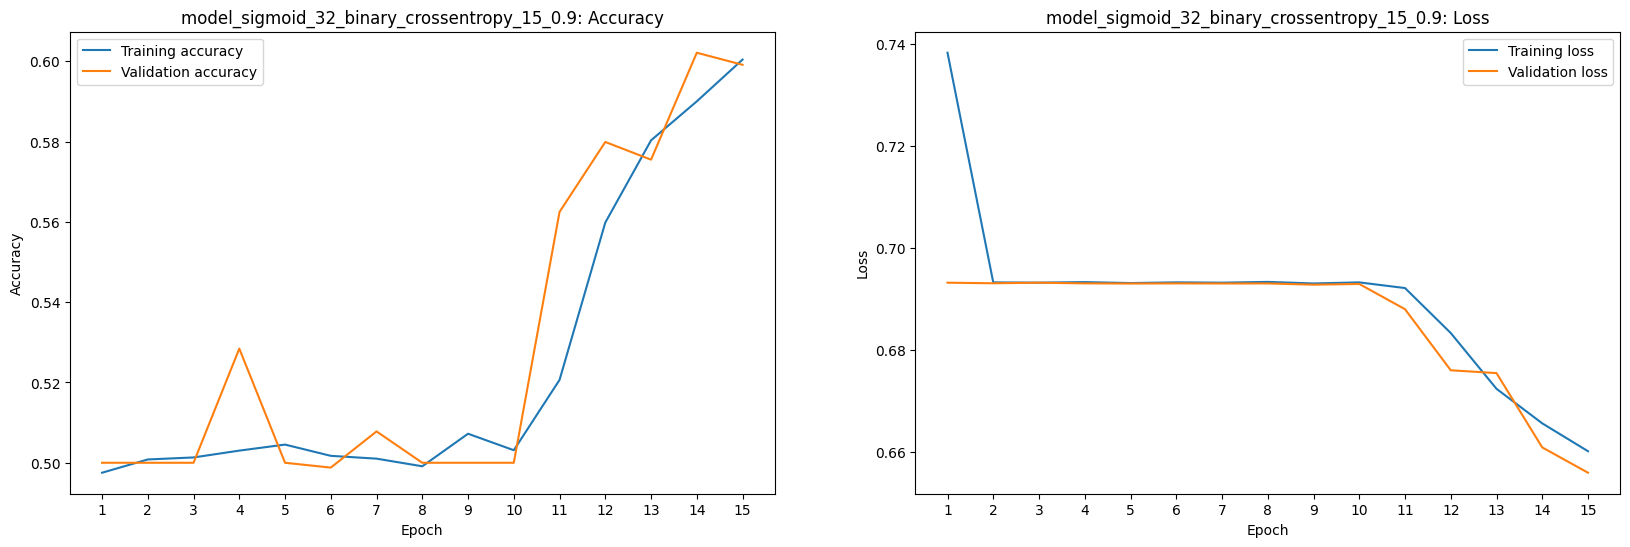

Model: model_sigmoid_64_binary_crossentropy_15_0.5, best validation accuracy: 0.5


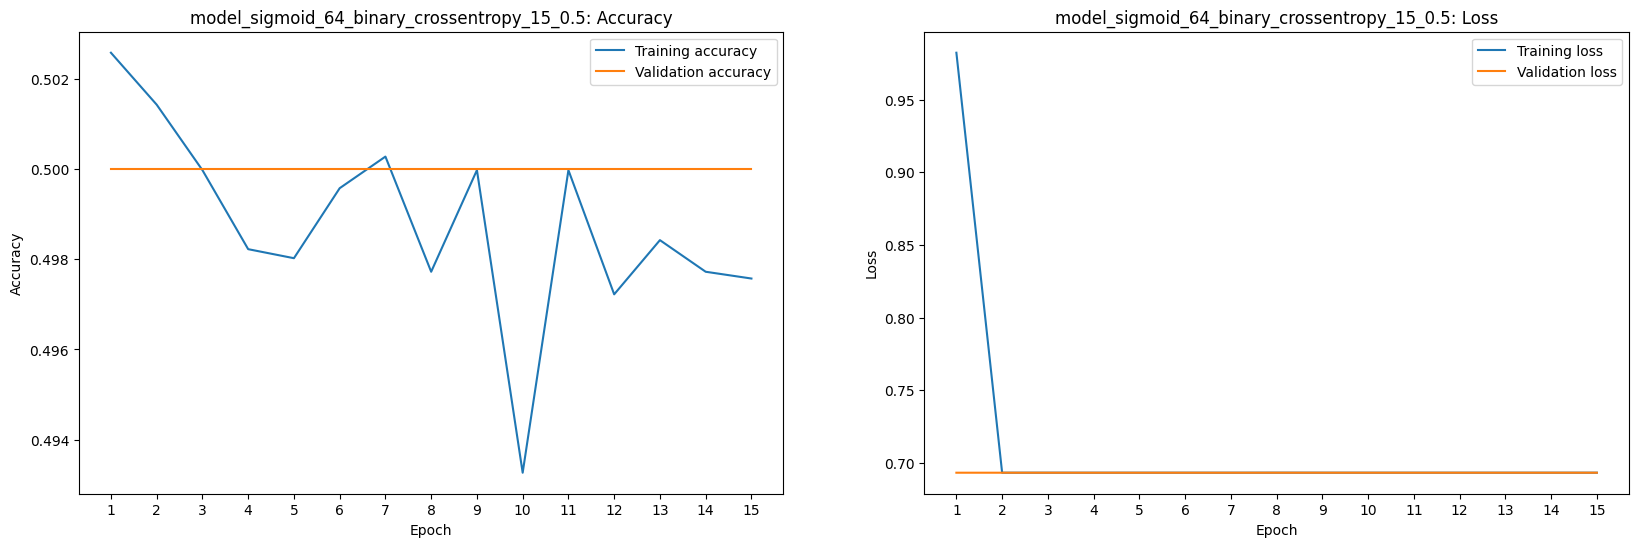

Model: model_sigmoid_64_binary_crossentropy_15_0.9, best validation accuracy: 0.5


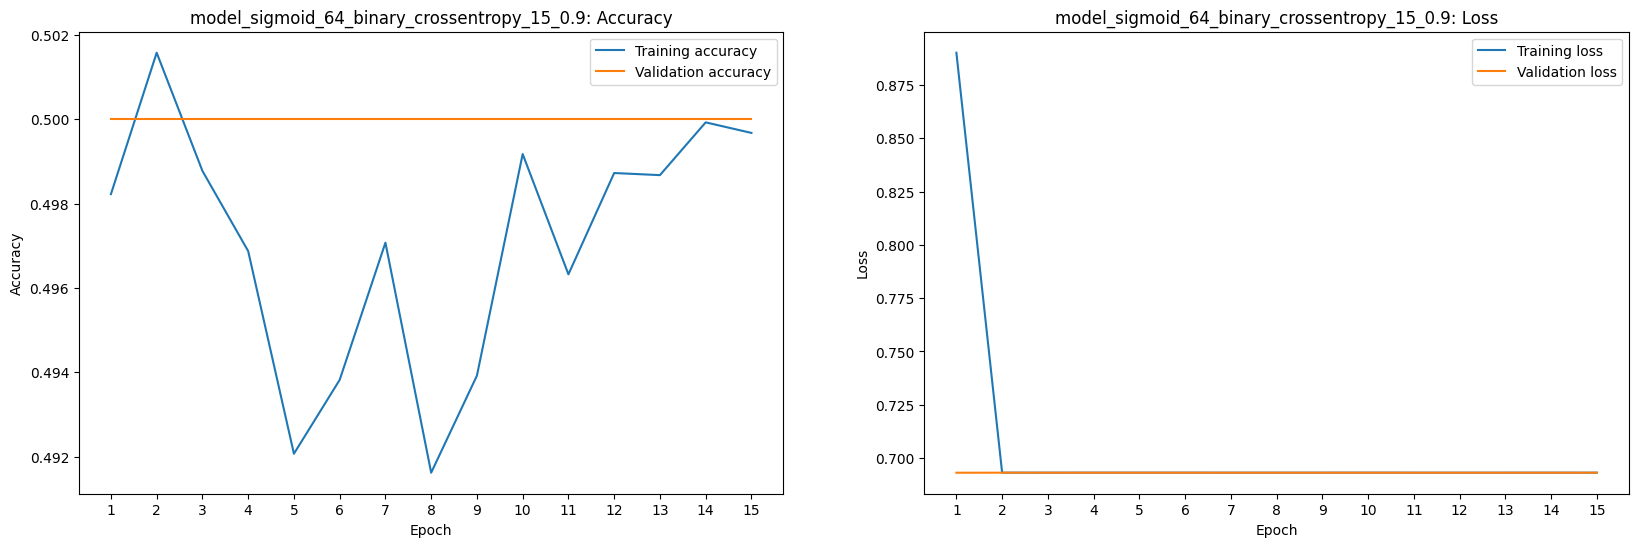

In [22]:
def plot_results_grid(results, save_dir='C:/dev/programming_2023/cnn_project/training_plots'):

    for i, result in enumerate(results):
        model_name = result['model_name']
        accuracy = result['accuracy']
        validation_accuracy = result['validation_accuracy']
        loss = result['loss']
        validation_loss = result['validation_loss']
        epochs = range(1, len(accuracy) + 1)
        
        print("Model: {}, best validation accuracy: {}".format(model_name, max(validation_accuracy)))

        fig, axes = plt.subplots(1, 2, figsize=(20, 6))

        # Plot accuracy
        axes[0].set_title(f"{model_name}: Accuracy")
        axes[0].plot(epochs, accuracy, label='Training accuracy')
        axes[0].plot(epochs, validation_accuracy, label='Validation accuracy')
        axes[0].set_xlabel("Epoch")
        axes[0].set_xticks(epochs)
        axes[0].set_ylabel("Accuracy")
        axes[0].legend()

        # Plot loss
        axes[1].set_title(f"{model_name}: Loss")
        axes[1].plot(epochs, loss, label='Training loss')
        axes[1].plot(epochs, validation_loss, label='Validation loss')
        axes[1].set_xlabel("Epoch")
        axes[1].set_xticks(epochs)
        axes[1].set_ylabel("Loss")
        axes[1].legend()

        # Save the figure
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        plt.show()
        fig.savefig(os.path.join(save_dir, f"{model_name}.png"))
        plt.close(fig)  # Close the figure to save memory

# Call the function with the results list
plot_results_grid(results)


# Appendix

In [ ]:
# generator to preprocess the images
# reshape to 256x256
# batch size of 50 images, split 

batch_size = 200
height, width = (256, 256)

# instantiate the base generator to split our set, normalize to 255
base_generator = ImageDataGenerator(
    rescale=1/255,
    validation_split=0.2
)

train_dataset = base_generator.flow_from_directory(
    BASE_IMAGE_DIR,
    target_size=(height, width),
    classes=('Cat', 'Dog'),
    batch_size=batch_size,
    subset='training',
)

validation_dataset = base_generator.flow_from_directory(
    BASE_IMAGE_DIR,
    target_size=(height, width),
    classes=('Cat', 'Dog'),
    batch_size=batch_size,
    subset='validation',
)


# ensure image labelling works properly
# i = 0
# while True:
#     i += 1
#     batch = train_dataset.next ()
#     print("Label is: {}".format(batch[1][0]))
#     plt.imshow(batch[0][0].astype(int))
#     plt.show()
#     if i == 10:
#         break

## Build  CNN model

In [ ]:
# define a sequential model
model = keras.models.Sequential()

# first layer, 24 filters with a kernel size of 5
# first layher needs input shape
model.add(
    keras.layers.Conv2D(
        24, 5, input_shape=(256, 256, 3),
        activation='relu',
    )
)

model.add( keras.layers.MaxPooling2D(2) )

model.add( 
    keras.layers.Conv2D(
        48, 5, activation='relu', 
    )
)
model.add( keras.layers.MaxPooling2D(2) )

model.add( 
    keras.layers.Conv2D(
        96, 5, activation='relu', 
    )
)

model.add( keras.layers.Flatten() )

# dropout to prevent overfitting
model.add( keras.layers.Dropout(0.9) )

# final layer, 2 output units with softmax to normalize probability outputs
model.add( keras.layers.Dense(
    2, activation='softmax',
    )
)

model.summary()

## train the model

In [ ]:
model.compile(
        loss='binary_crossentropy',
        optimizer=keras.optimizers.Adamax(learning_rate=.001),
        metrics=['acc']
    )


# this should run on GPU
history = model.fit(
    train_dataset, 
    validation_data=validation_dataset,
    workers=10,
    epochs=20
)

print("Saving model...")
model.save("{}/{}".format(TRAINED_MODELS_DIR, "model_1"))


In [ ]:
# plot the 
accuracy = history.history['acc']
validation_accuracy = history.history['val_acc']
loss = history.history['loss']
validation_loss = history.history['val_loss']
epochs = history.epoch

fig, ax = plt.subplots(1, 2, figsize=(20,6))

ax[0].plot(epochs, accuracy, label='Training accuracy')
ax[0].plot(epochs, validation_accuracy, label='Validation accuracy')
ax[0].set_xlabel("Epoch")
ax[0].set_xticks(epochs)
ax[0].set_ylabel("Accuracy")
ax[0].legend()

ax[1].plot(epochs, loss, label='Training loss')
ax[1].plot(epochs, validation_loss, label='Validation loss')
ax[1].set_xlabel("Epoch")
ax[1].set_xticks(epochs)
ax[1].set_ylabel("Loss")
ax[1].legend()

plt.show()

## Data Augmentation??

In [ ]:
TEST_CAT_DIR = r'C:\dev\programming_2023\cnn_project\test_cat'
        
first_images = os.listdir(TEST_CAT_DIR)[:20]
for image in first_images:
    test_img_path = "{}/{}".format(TEST_CAT_DIR, image)
    
    test_img =  cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
    
    # resize to  the net's inputs, normalize, and expant dims (for batch tensor)
    test_img = cv2.resize(test_img, (256, 256), interpolation=cv2.INTER_LINEAR)
    test_img = test_img.astype('float32') / 255.0
    test_img_expanded = np.expand_dims(test_img, axis=0)
    
    print(np.shape(test_img_expanded))
    break

    class_probabilities = model.predict(test_img_expanded)
    
    plt.imshow(test_img)
    plt.show()
    


In [ ]:
TEST_DOG_DIR = r'C:\dev\programming_2023\cnn_project\test_dog'
        
first_images = os.listdir(TEST_DOG_DIR)
for image in first_images:
    test_img_path = "{}/{}".format(TEST_DOG_DIR, image)
    
    test_img =  cv2.cvtColor(cv2.imread(test_img_path), cv2.COLOR_BGR2RGB)
    
    # resize to  the net's inputs, normalize, and expant dims (for batch tensor)
    test_img = cv2.resize(test_img, (256, 256), interpolation=cv2.INTER_LINEAR)
    test_img = test_img.astype('float32') / 255.0
    test_img_expanded = np.expand_dims(test_img, axis=0)
    
    print(np.shape(test_img_expanded))

    class_probabilities = model.predict(test_img_expanded)
    print("cat: {} dog: {}".format(class_probabilities[0][0], class_probabilities[0][1]))
    
    plt.imshow(test_img)
    plt.show()